# HANDWRITTEN DIGITS RECOGNITION FOR MNIST DATASET

The dataset has been downloaded from kaggle and it contains 785 columns for multiclass classification, representing 10 different digits. I encoded these dependent variables in a "one vs all modality" creating 10 different datasets. In this way, I was able to use the binary classifier Perceptron with the polynomial kernel. The notebook is structured in the following way, repeating actions for each digit:

1. binary classifier computed with polyonomial degree = 2 and number of epochs = 5.
2. computing training and test accuracy for the "minimum training error" classifier, "average" classifier and "weighted average" classifier.
3. Tuning hyperparamters with validation set approach.
4. Tuning hyperparamters with CV approach.
5. Models retrained with both the hyperparamter "types" selected and comparisons among training and test accuracies and with classifers of point number 2).
6. Multiclassification with classifiers computed at point 5).
7. Multiclassification using fixed hyperparamters for each binary classifier and comparison with performances of point 6).

## DATA MANIPULATION

In [1]:
# Needed libraries and loading datasets.

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
mnist_train = pd.read_csv("C:\\Users\\Matteo\\Desktop\\MACHINE LEARNING SLIDES\\mnist_train.csv")
mnist_test = pd.read_csv("C:\\Users\\Matteo\\Desktop\\MACHINE LEARNING SLIDES\\mnist_test.csv")

In [2]:
labels = list(mnist_train['label'])
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
onehot_encoder = OneHotEncoder(sparse = False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
def minusone(array):
    new_list = []
    for el in array:
        internal_list = []
        for i in el:
            if i == 0.0:
                internal_list.append(-1.0)
            else:
                internal_list.append(i)
        new_list.append(internal_list)        
    return new_list
labelled = pd.DataFrame(minusone(onehot_encoded))
print(labelled)

         0    1    2    3    4    5    6    7    8    9
0     -1.0 -1.0 -1.0 -1.0 -1.0  1.0 -1.0 -1.0 -1.0 -1.0
1      1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
2     -1.0 -1.0 -1.0 -1.0  1.0 -1.0 -1.0 -1.0 -1.0 -1.0
3     -1.0  1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
4     -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  1.0
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
59995 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  1.0 -1.0
59996 -1.0 -1.0 -1.0  1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
59997 -1.0 -1.0 -1.0 -1.0 -1.0  1.0 -1.0 -1.0 -1.0 -1.0
59998 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  1.0 -1.0 -1.0 -1.0
59999 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  1.0 -1.0

[60000 rows x 10 columns]


In [3]:
labels = list(mnist_test['label'])
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
onehot_encoder = OneHotEncoder(sparse = False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
labelled_test = pd.DataFrame(minusone(onehot_encoded))

## FUNCTION DEFINITIONS FOR COMPUTING TRAINING ERRORS

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


def kern(x1,x2,d=2,c=1):
    pre = c + np.dot(x1.T,x2)
    ret = pre**d
    return ret

def mapps(array):
    return ([kern(array[k][:-1],array[row_index][:-1]) for row_index in range(len(array)) for k in range(len(array))])

def splits(array,n_examples):
    return([array[i:i+n_examples] for i in range(0,n_examples**2,n_examples)])

def mapps_2(array,d):
    map = np.array([[None]*len(array)]*len(array))
    for row_index in range(len(array)):
        for k in range(row_index,len(array)):
                value = kern(array[k][:-1],array[row_index][:-1],d)
                map[row_index][k] = value
                map[k][row_index] = value
    return np.matrix(map)  

### Mapps_2 faster than mapps/split, they perform the same task.
# Mapps_2 possible only because the kernel matrices are symmetric ----> Mercer's theorem

def predict_test(train,test,alpha, row_index,d):
    activation = 0
    for k in range(len(train)):
        activation += alpha[k]*kern(train[k][:-1],test[row_index][:-1],d)  
    return 1.0 if activation >= 0.0 else -1.0

def predict_2(array,alpha, row_index, kernels):
    activation = np.dot(kernels[row_index],alpha)
    return 1.0 if activation >= 0.0 else -1.0

def train_kern_alpha(train, n_epoch, kernels): #train --> dataset to train
    alpha_list = []
    alpha = np.array([0.0 for i in range(len(train))])
    n_errors = []
    for epoch in range(n_epoch):
        sum_error = 0.0
        for i in range(len(train)):
            prediction = predict_2(train, alpha, i, kernels)
            error = (train[i][-1] - prediction)/2
            sum_error += error**2
            alpha[i] += error
        print('>epoch=%d, error=%.3f' % (epoch, sum_error))
        c = list(alpha).copy()
        n_errors.append(sum_error)
        alpha_list.append(c)
    print('average error = %2f' % (sum(n_errors)/len(n_errors)))    
    return (alpha,alpha_list,n_errors)

# train_kern_alpha(xtrainsmall,8)
# type(kern(xtrainsmall[0],xtrainsmall[1])) == np.float64 #True

def kernel_perceptron(train, test, n_epoch, kernels,d):
    predictions_tr = list()
    predictions_test = list()
    alpha,alpha_list,errors = train_kern_alpha(train, n_epoch, kernels)
    print(alpha)
    for row in range(len(train)):
        prediction = predict_2(train,alpha,row,kernels)
        predictions_tr.append(prediction)
    for row in range(len(test)):
        prediction = predict_test(train,test,alpha,row,d)
        predictions_test.append(prediction)
    return(predictions_tr,predictions_test,alpha_list,errors)

def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

def alpha_avg(alpha_list):
    avg = []
    for i in range(len(alpha_list[0])):
        count = 0
        for l in range(len(alpha_list)):
            count += alpha_list[l][i]
        avg.append(count/len(alpha_list))
    return avg

def weight_avg(alpha_list, scaled_n_err):
    avg = []
    for i in range(len(alpha_list[0])):
        count = 0
        for l in range(len(alpha_list)):
            count += alpha_list[l][i]*scaled_n_err[l]
        avg.append(count)
    return avg

def scaling(n_err):
    scaling = []
    for i in n_err:
        scaling.append(1/i)
    scaled = []
    for el in scaling:
        scaled.append(el/sum(scaling))
    return scaled  

In [5]:
best_tr_acc = []
best_test_acc = []
avg_accuracies = []
weighted_avg = []
errors_collection = []

In [6]:
mnist_test

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## FIRST EXERCISE: COMPUTING TRAINING ERROR

### DIGIT 0 ANALYSIS

In [7]:
# Creating the dataset

base = mnist_train.iloc[:,1:]
base['0'] = labelled.iloc[:,0]
onehot_digit0 = base
onehot_digit0

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0


In [8]:
base_test = mnist_test.iloc[:,1:]
base_test['0'] = labelled_test.iloc[:,0]
onehot_digit0_test = base_test
onehot_digit0_test

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0


In [9]:
# Defining sets

xtrain = np.array(onehot_digit0)
xtest = np.array(onehot_digit0_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

# Kernel map, it's the same for all the digits
kernels = mapps_2(xtrainsmall,2)

In [10]:
predicted_tr,predicted_test0,alpha_list,err0 = kernel_perceptron(xtrainsmall,xtestsmall, 5, kernels, 2)
errors_collection.append(err0)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in xtestsmall]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test0)))
best_test_acc.append(accuracy_metric(actual, predicted_test0))

>epoch=0, error=141.000
>epoch=1, error=46.000
>epoch=2, error=35.000
>epoch=3, error=17.000
>epoch=4, error=23.000
average error = 52.400000
[-1.  1. -1. ...  0.  0.  0.]
training accuracy = 99.80
test accuracy = 99.20


In [11]:
alpha_medio = alpha_avg(alpha_list)
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,alpha_medio,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('average training accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_accuracies.append(accuracy_metric(actual, group))

average training accuracy = 99.90


In [12]:
weighted_averaged  = weight_avg(alpha_list,scaling(err0))
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg.append(accuracy_metric(actual, group))

weighted average training accuracy = 99.94


### DIGIT 1 ANALYSIS

In [13]:
base = mnist_train.iloc[:,1:]
base['1'] = labelled.iloc[:,1]
onehot_digit1 = base
onehot_digit1

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0


In [14]:
base_test = mnist_test.iloc[:,1:]
base_test['1'] = labelled_test.iloc[:,1]
onehot_digit1_test = base_test
onehot_digit1_test

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0


In [15]:
xtrain = np.array(onehot_digit1)
xtest = np.array(onehot_digit1_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [16]:
predicted_tr,predicted_test1, alpha_list1,err1 = kernel_perceptron(xtrainsmall,xtestsmall, 5, kernels, 2)
errors_collection.append(err1)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in xtestsmall]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test1)))
best_test_acc.append(accuracy_metric(actual, predicted_test1))

>epoch=0, error=123.000
>epoch=1, error=61.000
>epoch=2, error=50.000
>epoch=3, error=38.000
>epoch=4, error=23.000
average error = 59.000000
[-1.  0.  0. ...  0.  0.  0.]
training accuracy = 99.89
test accuracy = 99.50


In [17]:
alpha_medio = alpha_avg(alpha_list1)
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,alpha_medio,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('average training accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_accuracies.append(accuracy_metric(actual, group))

average training accuracy = 99.69


In [18]:
weighted_averaged  = weight_avg(alpha_list1,scaling(err1))
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg.append(accuracy_metric(actual, group))

weighted average training accuracy = 99.81


### DIGIT 2 ANALYSIS

In [19]:
base = mnist_train.iloc[:,1:]
base['2'] = labelled.iloc[:,2]
onehot_digit2 = base
onehot_digit2

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0


In [20]:
base_test = mnist_test.iloc[:,1:]
base_test['2'] = labelled_test.iloc[:,2]
onehot_digit2_test = base_test
onehot_digit2_test

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0


In [21]:
xtrain = np.array(onehot_digit2)
xtest = np.array(onehot_digit2_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

predicted_tr,predicted_test2,alpha_list2,err2 = kernel_perceptron(xtrainsmall,xtestsmall, 5, kernels, 2)
errors_collection.append(err2)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in xtestsmall]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test2)))
best_test_acc.append(accuracy_metric(actual, predicted_test2))

>epoch=0, error=252.000
>epoch=1, error=91.000
>epoch=2, error=57.000
>epoch=3, error=48.000
>epoch=4, error=16.000
average error = 92.800000
[-1.  0. -1. ...  0.  0.  0.]
training accuracy = 99.80
test accuracy = 98.30


In [22]:
alpha_medio = alpha_avg(alpha_list2)
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,alpha_medio,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('average training accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_accuracies.append(accuracy_metric(actual, group))

average training accuracy = 99.86


In [23]:
weighted_averaged  = weight_avg(alpha_list2,scaling(err2))
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg.append(accuracy_metric(actual, group))

weighted average training accuracy = 99.88


### DIGIT 3 ANALYSIS

In [24]:
base = mnist_train.iloc[:,1:]
base['3'] = labelled.iloc[:,3]
onehot_digit3 = base
onehot_digit3

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0


In [25]:
base_test = mnist_test.iloc[:,1:]
base_test['3'] = labelled_test.iloc[:,3]
onehot_digit3_test = base_test
onehot_digit3_test

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0


In [26]:
xtrain = np.array(onehot_digit3)
xtest = np.array(onehot_digit3_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

predicted_tr,predicted_test3,alpha_list3,err3 = kernel_perceptron(xtrainsmall,xtestsmall, 5, kernels, 2)
errors_collection.append(err3)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in xtestsmall]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test3)))
best_test_acc.append(accuracy_metric(actual, predicted_test3))

>epoch=0, error=283.000
>epoch=1, error=132.000
>epoch=2, error=81.000
>epoch=3, error=65.000
>epoch=4, error=41.000
average error = 120.400000
[-1.  0.  0. ...  0.  0.  0.]
training accuracy = 99.39
test accuracy = 98.35


In [27]:
alpha_medio = alpha_avg(alpha_list3)
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,alpha_medio,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_accuracies.append(accuracy_metric(actual, group))

weighted average training accuracy = 99.49


In [28]:
weighted_averaged  = weight_avg(alpha_list3,scaling(err3))
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg.append(accuracy_metric(actual, group))

weighted average training accuracy = 99.50


### DIGIT 4 ANALYSIS

In [29]:
base = mnist_train.iloc[:,1:]
base['4'] = labelled.iloc[:,4]
onehot_digit4 = base
onehot_digit4

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,4
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0


In [30]:
base_test = mnist_test.iloc[:,1:]
base_test['4'] = labelled_test.iloc[:,4]
onehot_digit4_test = base_test
onehot_digit4_test

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,4
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0


In [31]:
xtrain = np.array(onehot_digit4)
xtest = np.array(onehot_digit4_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

predicted_tr,predicted_test4,alpha_list4,err4 = kernel_perceptron(xtrainsmall,xtestsmall, 5, kernels, 2)
errors_collection.append(err4)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in xtestsmall]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test4)))
best_test_acc.append(accuracy_metric(actual, predicted_test4))

>epoch=0, error=234.000
>epoch=1, error=78.000
>epoch=2, error=42.000
>epoch=3, error=22.000
>epoch=4, error=29.000
average error = 81.000000
[-1.  0.  1. ...  0.  0.  0.]
training accuracy = 99.91
test accuracy = 98.65


In [32]:
alpha_medio = alpha_avg(alpha_list4)
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,alpha_medio,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('average training accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_accuracies.append(accuracy_metric(actual, group))

average training accuracy = 99.88


In [33]:
weighted_averaged  = weight_avg(alpha_list4,scaling(err4))
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg.append(accuracy_metric(actual, group))

weighted average training accuracy = 99.95


### DIGIT ANALYSIS 5

In [34]:
base = mnist_train.iloc[:,1:]
base['5'] = labelled.iloc[:,5]
onehot_digit5 = base
onehot_digit5

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,5
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0


In [35]:
base_test = mnist_test.iloc[:,1:]
base_test['5'] = labelled_test.iloc[:,5]
onehot_digit5_test = base_test
onehot_digit5_test

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,5
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [36]:
xtrain = np.array(onehot_digit5)
xtest = np.array(onehot_digit5_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

predicted_tr,predicted_test5,alpha_list5,err5 = kernel_perceptron(xtrainsmall,xtestsmall, 5, kernels, 2)
errors_collection.append(err5)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in xtestsmall]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test5)))
best_test_acc.append(accuracy_metric(actual, predicted_test5))

>epoch=0, error=248.000
>epoch=1, error=100.000
>epoch=2, error=73.000
>epoch=3, error=39.000
>epoch=4, error=32.000
average error = 98.400000
[ 0. -1.  0. ...  0.  0.  0.]
training accuracy = 99.88
test accuracy = 98.90


In [37]:
alpha_medio = alpha_avg(alpha_list5)
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,alpha_medio,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('average training accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_accuracies.append(accuracy_metric(actual, group))

average training accuracy = 99.83


In [38]:
weighted_averaged  = weight_avg(alpha_list5,scaling(err5))
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg.append(accuracy_metric(actual, group))

weighted average training accuracy = 99.86


### DIGIT ANALYSIS 6

In [39]:
base = mnist_train.iloc[:,1:]
base['6'] = labelled.iloc[:,6]
onehot_digit6 = base
onehot_digit6

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,6
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [40]:
base_test = mnist_test.iloc[:,1:]
base_test['6'] = labelled_test.iloc[:,6]
onehot_digit6_test = base_test
onehot_digit6_test

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,6
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0


In [41]:
xtrain = np.array(onehot_digit6.iloc[:48000,:])
xtest = np.array(onehot_digit6.iloc[48000:,:])
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

predicted_tr,predicted_test6,alpha_list6,err6 = kernel_perceptron(xtrainsmall,xtestsmall, 5, kernels, 2)
errors_collection.append(err6)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in xtestsmall]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test6)))
best_test_acc.append(accuracy_metric(actual, predicted_test6))

>epoch=0, error=165.000
>epoch=1, error=77.000
>epoch=2, error=49.000
>epoch=3, error=21.000
>epoch=4, error=18.000
average error = 66.000000
[-1.  0.  0. ...  0.  0.  0.]
training accuracy = 99.66
test accuracy = 98.90


In [42]:
alpha_medio = alpha_avg(alpha_list6)
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,alpha_medio,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('average training accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_accuracies.append(accuracy_metric(actual, group))

average training accuracy = 99.91


In [43]:
weighted_averaged  = weight_avg(alpha_list6,scaling(err6))
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg.append(accuracy_metric(actual, group))

weighted average training accuracy = 99.90


### DIGIT 7 ANALYSIS

In [44]:
base = mnist_train.iloc[:,1:]
base['7'] = labelled.iloc[:,7]
onehot_digit7 = base
onehot_digit7

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,7
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0


In [45]:
base_test = mnist_test.iloc[:,1:]
base_test['7'] = labelled_test.iloc[:,7]
onehot_digit7_test = base_test
onehot_digit7_test

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,7
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0


In [46]:
xtrain = np.array(onehot_digit7)
xtest = np.array(onehot_digit7_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

predicted_tr,predicted_test7,alpha_list7,err7 = kernel_perceptron(xtrainsmall,xtestsmall, 5, kernels, 2)
errors_collection.append(err7)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in xtestsmall]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test7)))
best_test_acc.append(accuracy_metric(actual, predicted_test7))

>epoch=0, error=207.000
>epoch=1, error=96.000
>epoch=2, error=66.000
>epoch=3, error=34.000
>epoch=4, error=38.000
average error = 88.200000
[-1.  0.  0. ...  0.  0.  0.]
training accuracy = 99.61
test accuracy = 97.75


In [47]:
alpha_medio = alpha_avg(alpha_list7)
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,alpha_medio,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('average training accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_accuracies.append(accuracy_metric(actual, group))

average training accuracy = 99.72


In [48]:
weighted_averaged  = weight_avg(alpha_list7,scaling(err7))
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg.append(accuracy_metric(actual, group))

weighted average training accuracy = 99.75


### DIGIT 8 ANALYSIS

In [49]:
base = mnist_train.iloc[:,1:]
base['8'] = labelled.iloc[:,8]
onehot_digit8 = base
onehot_digit8

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,8
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0


In [50]:
base_test = mnist_test.iloc[:,1:]
base_test['8'] = labelled_test.iloc[:,8]
onehot_digit8_test = base_test
onehot_digit8_test

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,8
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0


In [51]:
xtrain = np.array(onehot_digit8)
xtest = np.array(onehot_digit8_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

predicted_tr,predicted_test8,alpha_list8,err8 = kernel_perceptron(xtrainsmall,xtestsmall, 5, kernels, 2)
errors_collection.append(err8)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in xtestsmall]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test8)))
best_test_acc.append(accuracy_metric(actual, predicted_test8))

>epoch=0, error=396.000
>epoch=1, error=146.000
>epoch=2, error=106.000
>epoch=3, error=69.000
>epoch=4, error=53.000
average error = 154.000000
[-1.  0.  0. ...  0.  0.  0.]
training accuracy = 98.89
test accuracy = 97.10


In [52]:
alpha_medio = alpha_avg(alpha_list8)
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,alpha_medio,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('average training accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_accuracies.append(accuracy_metric(actual, group))

average training accuracy = 99.52


In [53]:
weighted_averaged  = weight_avg(alpha_list8,scaling(err8))
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg.append(accuracy_metric(actual, group))

weighted average training accuracy = 99.71


### DIGIT 9 ANALYSIS

In [54]:
base = mnist_train.iloc[:,1:]
base['9'] = labelled.iloc[:,9]
onehot_digit9 = base
onehot_digit9

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,9
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0


In [55]:
base_test = mnist_test.iloc[:,1:]
base_test['9'] = labelled_test.iloc[:,9]
onehot_digit9_test = base_test
onehot_digit9_test

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,9
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.0


In [56]:
xtrain = np.array(onehot_digit9)
xtest = np.array(onehot_digit9_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

predicted_tr,predicted_test9,alpha_list9,err9 = kernel_perceptron(xtrainsmall,xtestsmall, 5, kernels, 2)
errors_collection.append(err9)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in xtestsmall]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test9)))
best_test_acc.append(accuracy_metric(actual, predicted_test9))

>epoch=0, error=383.000
>epoch=1, error=187.000
>epoch=2, error=100.000
>epoch=3, error=92.000
>epoch=4, error=85.000
average error = 169.400000
[-1.  0.  0. ...  0.  0.  0.]
training accuracy = 99.59
test accuracy = 97.45


In [57]:
alpha_medio = alpha_avg(alpha_list9)
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,alpha_medio,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('average training accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_accuracies.append(accuracy_metric(actual, group))

average training accuracy = 99.60


In [58]:
weighted_averaged  = weight_avg(alpha_list9,scaling(err9))
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_2(xtrainsmall,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg.append(accuracy_metric(actual, group))

weighted average training accuracy = 99.75


## SUMMING UP TRAINING ERROR RESULTS

Considering 5 epochs for the training and a degree expansion of order 2 of the kernel, the training accuracy of the 10 binary classifiers, one for each digit, is reported below.

In [59]:
for i in range(10):
    print('training accuracy of kernel Perceptron for digit %d = %.2f, average training error = %.2f, min training error with %.2d epochs' % (i, best_tr_acc[i],sum(errors_collection[i])/len(errors_collection[i]),errors_collection[i].index(min(errors_collection[i]))+1))

training accuracy of kernel Perceptron for digit 0 = 99.80, average training error = 52.40, min training error with 04 epochs
training accuracy of kernel Perceptron for digit 1 = 99.89, average training error = 59.00, min training error with 05 epochs
training accuracy of kernel Perceptron for digit 2 = 99.80, average training error = 92.80, min training error with 05 epochs
training accuracy of kernel Perceptron for digit 3 = 99.39, average training error = 120.40, min training error with 05 epochs
training accuracy of kernel Perceptron for digit 4 = 99.91, average training error = 81.00, min training error with 04 epochs
training accuracy of kernel Perceptron for digit 5 = 99.88, average training error = 98.40, min training error with 05 epochs
training accuracy of kernel Perceptron for digit 6 = 99.66, average training error = 66.00, min training error with 05 epochs
training accuracy of kernel Perceptron for digit 7 = 99.61, average training error = 88.20, min training error with 0

In [60]:
for el in range(10):
    print('average training accuracy for digit %d = %.2f, weighted average training accuracy = %.2f' % (el,avg_accuracies[el],weighted_avg[el]))

average training accuracy for digit 0 = 99.90, weighted average training accuracy = 99.94
average training accuracy for digit 1 = 99.69, weighted average training accuracy = 99.81
average training accuracy for digit 2 = 99.86, weighted average training accuracy = 99.88
average training accuracy for digit 3 = 99.49, weighted average training accuracy = 99.50
average training accuracy for digit 4 = 99.88, weighted average training accuracy = 99.95
average training accuracy for digit 5 = 99.83, weighted average training accuracy = 99.86
average training accuracy for digit 6 = 99.91, weighted average training accuracy = 99.90
average training accuracy for digit 7 = 99.72, weighted average training accuracy = 99.75
average training accuracy for digit 8 = 99.52, weighted average training accuracy = 99.71
average training accuracy for digit 9 = 99.60, weighted average training accuracy = 99.75


## TESTING THE PREVIOUS MODEL

### AVERAGE AND WEIGHTED AVERAGE MODELS

In [61]:
avg_test_acc = []
weighted_avg_test_acc = []

### DIGIT 0

In [62]:
xtrain = np.array(onehot_digit0)
xtest = np.array(onehot_digit0_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

# Kernel map, it's the same for all the digits
kernels = mapps_2(xtrainsmall,2)

In [63]:
alpha_medio = alpha_avg(alpha_list)
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall, xtestsmall,alpha_medio,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('average test accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_test_acc.append(accuracy_metric(actual, group))

average test accuracy = 99.55


In [64]:
weighted_averaged  = weight_avg(alpha_list,scaling(err0))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, weighted_averaged,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg_test_acc.append(accuracy_metric(actual, group))

weighted average test accuracy = 99.40


### DIGIT 1

In [65]:
xtrain = np.array(onehot_digit1)
xtest = np.array(onehot_digit1_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [66]:
alpha_medio = alpha_avg(alpha_list1)
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall, xtestsmall,alpha_medio,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('average test accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_test_acc.append(accuracy_metric(actual, group))

average test accuracy = 99.40


In [67]:
weighted_averaged  = weight_avg(alpha_list1,scaling(err1))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, weighted_averaged,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg_test_acc.append(accuracy_metric(actual, group))

weighted average test accuracy = 99.40


### DIGIT 2

In [68]:
xtrain = np.array(onehot_digit2)
xtest = np.array(onehot_digit2_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [69]:
alpha_medio = alpha_avg(alpha_list2)
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall, xtestsmall,alpha_medio,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('average test accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_test_acc.append(accuracy_metric(actual, group))

average test accuracy = 98.60


In [70]:
weighted_averaged  = weight_avg(alpha_list2,scaling(err2))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, weighted_averaged,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg_test_acc.append(accuracy_metric(actual, group))

weighted average test accuracy = 98.65


### DIGIT 3

In [71]:
xtrain = np.array(onehot_digit3)
xtest = np.array(onehot_digit3_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [72]:
alpha_medio = alpha_avg(alpha_list3)
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall, xtestsmall,alpha_medio,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('average test accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_test_acc.append(accuracy_metric(actual, group))

average test accuracy = 98.75


In [73]:
weighted_averaged  = weight_avg(alpha_list3,scaling(err3))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, weighted_averaged,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg_test_acc.append(accuracy_metric(actual, group))

weighted average test accuracy = 98.75


### DIGIT 4

In [74]:
xtrain = np.array(onehot_digit4)
xtest = np.array(onehot_digit4_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [75]:
alpha_medio = alpha_avg(alpha_list4)
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall, xtestsmall,alpha_medio,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('average test accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_test_acc.append(accuracy_metric(actual, group))

average test accuracy = 98.55


In [76]:
weighted_averaged  = weight_avg(alpha_list4,scaling(err4))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, weighted_averaged,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg_test_acc.append(accuracy_metric(actual, group))

weighted average test accuracy = 98.65


### DIGIT 5

In [77]:
xtrain = np.array(onehot_digit5)
xtest = np.array(onehot_digit5_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [78]:
alpha_medio = alpha_avg(alpha_list5)
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall, xtestsmall,alpha_medio,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('average test accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_test_acc.append(accuracy_metric(actual, group))

average test accuracy = 99.00


In [79]:
weighted_averaged  = weight_avg(alpha_list5,scaling(err5))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, weighted_averaged,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg_test_acc.append(accuracy_metric(actual, group))

weighted average test accuracy = 98.85


### DIGIT 6

In [80]:
xtrain = np.array(onehot_digit6)
xtest = np.array(onehot_digit6_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [81]:
alpha_medio = alpha_avg(alpha_list6)
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall, xtestsmall,alpha_medio,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('average test accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_test_acc.append(accuracy_metric(actual, group))

average test accuracy = 98.65


In [82]:
weighted_averaged  = weight_avg(alpha_list6,scaling(err6))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, weighted_averaged,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg_test_acc.append(accuracy_metric(actual, group))

weighted average test accuracy = 98.65


### DIGIT 7

In [83]:
xtrain = np.array(onehot_digit7)
xtest = np.array(onehot_digit7_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [84]:
alpha_medio = alpha_avg(alpha_list7)
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall, xtestsmall,alpha_medio,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('average test accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_test_acc.append(accuracy_metric(actual, group))

average test accuracy = 98.20


In [85]:
weighted_averaged  = weight_avg(alpha_list7,scaling(err7))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, weighted_averaged,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg_test_acc.append(accuracy_metric(actual, group))

weighted average test accuracy = 98.20


### DIGIT 8

In [86]:
xtrain = np.array(onehot_digit8)
xtest = np.array(onehot_digit8_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [87]:
alpha_medio = alpha_avg(alpha_list8)
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall, xtestsmall,alpha_medio,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('average test accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_test_acc.append(accuracy_metric(actual, group))

average test accuracy = 97.65


In [88]:
weighted_averaged  = weight_avg(alpha_list8,scaling(err8))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, weighted_averaged,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg_test_acc.append(accuracy_metric(actual, group))

weighted average test accuracy = 97.75


### DIGIT 9

In [89]:
xtrain = np.array(onehot_digit9)
xtest = np.array(onehot_digit9_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [90]:
alpha_medio = alpha_avg(alpha_list9)
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall, xtestsmall,alpha_medio,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('average test accuracy = %.2f' % (accuracy_metric(actual, group)))
avg_test_acc.append(accuracy_metric(actual, group))

average test accuracy = 97.95


In [91]:
weighted_averaged  = weight_avg(alpha_list9,scaling(err9))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, weighted_averaged,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
weighted_avg_test_acc.append(accuracy_metric(actual, group))

weighted average test accuracy = 97.95


## MINIMUM TRAINING ERROR MODELS

In this section, the predictors which have the lowest training error among the five considered in each digit of the previous section are tested.

In [92]:
min_tr_test_acc = []
best_tr_acc = []

### DIGIT 0

In [93]:
xtrain = np.array(onehot_digit0)
xtest = np.array(onehot_digit0_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [94]:
alpha_sel = alpha_list[errors_collection[0].index(min(errors_collection[0]))]
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_test(xtrainsmall,xtrainsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
best_tr_acc.append(accuracy_metric(actual, group))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('test accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
min_tr_test_acc.append(accuracy_metric(actual, group))

training accuracy of min training error= 99.89
test accuracy of min training error= 99.70


### DIGIT 1

In [95]:
xtrain = np.array(onehot_digit1)
xtest = np.array(onehot_digit1_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [96]:
alpha_sel = alpha_list1[errors_collection[1].index(min(errors_collection[1]))]
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_test(xtrainsmall,xtrainsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
best_tr_acc.append(accuracy_metric(actual, group))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('test accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
min_tr_test_acc.append(accuracy_metric(actual, group))

training accuracy of min training error= 99.89
test accuracy of min training error= 99.50


### DIGIT 2

In [97]:
xtrain = np.array(onehot_digit2)
xtest = np.array(onehot_digit2_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [98]:
alpha_sel = alpha_list2[errors_collection[2].index(min(errors_collection[2]))]
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_test(xtrainsmall,xtrainsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
best_tr_acc.append(accuracy_metric(actual, group))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('test accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
min_tr_test_acc.append(accuracy_metric(actual, group))

training accuracy of min training error= 99.80
test accuracy of min training error= 98.30


### DIIGT 3

In [99]:
xtrain = np.array(onehot_digit3)
xtest = np.array(onehot_digit3_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [100]:
alpha_sel = alpha_list3[errors_collection[3].index(min(errors_collection[3]))]
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_test(xtrainsmall,xtrainsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
best_tr_acc.append(accuracy_metric(actual, group))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('test accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
min_tr_test_acc.append(accuracy_metric(actual, group))

training accuracy of min training error= 99.39
test accuracy of min training error= 98.35


### DIGIT 4

In [101]:
xtrain = np.array(onehot_digit4)
xtest = np.array(onehot_digit4_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [102]:
alpha_sel = alpha_list4[errors_collection[4].index(min(errors_collection[4]))]
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_test(xtrainsmall,xtrainsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
best_tr_acc.append(accuracy_metric(actual, group))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('test accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
min_tr_test_acc.append(accuracy_metric(actual, group))

training accuracy of min training error= 99.74
test accuracy of min training error= 98.45


### DIGIT 5

In [103]:
xtrain = np.array(onehot_digit5)
xtest = np.array(onehot_digit5_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [104]:
alpha_sel = alpha_list5[errors_collection[5].index(min(errors_collection[5]))]
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_test(xtrainsmall,xtrainsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
best_tr_acc.append(accuracy_metric(actual, group))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('test accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
min_tr_test_acc.append(accuracy_metric(actual, group))

training accuracy of min training error= 99.88
test accuracy of min training error= 98.90


### DIGIT 6

In [105]:
xtrain = np.array(onehot_digit6)
xtest = np.array(onehot_digit6_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [106]:
alpha_sel = alpha_list6[errors_collection[6].index(min(errors_collection[6]))]
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_test(xtrainsmall,xtrainsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
best_tr_acc.append(accuracy_metric(actual, group))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('test accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
min_tr_test_acc.append(accuracy_metric(actual, group))

training accuracy of min training error= 99.66
test accuracy of min training error= 98.40


### DIGIT 7

In [107]:
xtrain = np.array(onehot_digit7)
xtest = np.array(onehot_digit7_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [108]:
alpha_sel = alpha_list7[errors_collection[7].index(min(errors_collection[7]))]
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_test(xtrainsmall,xtrainsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
best_tr_acc.append(accuracy_metric(actual, group))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('test accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
min_tr_test_acc.append(accuracy_metric(actual, group))

training accuracy of min training error= 99.51
test accuracy of min training error= 98.00


### DIGIT 8

In [109]:
xtrain = np.array(onehot_digit8)
xtest = np.array(onehot_digit8_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [110]:
alpha_sel = alpha_list8[errors_collection[8].index(min(errors_collection[8]))]
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_test(xtrainsmall,xtrainsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
best_tr_acc.append(accuracy_metric(actual, group))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('test accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
min_tr_test_acc.append(accuracy_metric(actual, group))

training accuracy of min training error= 98.89
test accuracy of min training error= 97.10


### DIGIT 9

In [111]:
xtrain = np.array(onehot_digit9)
xtest = np.array(onehot_digit9_test)
xtrainsmall = xtrain[:8000]
xtestsmall = xtest[:2000]

In [112]:
alpha_sel = alpha_list9[errors_collection[9].index(min(errors_collection[9]))]
group = []
for row in range(len(xtrainsmall)):
        prediction = predict_test(xtrainsmall,xtrainsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtrainsmall]
print('training accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
best_tr_acc.append(accuracy_metric(actual, group))
group = []
for row in range(len(xtestsmall)):
        prediction = predict_test(xtrainsmall,xtestsmall, alpha_sel,row,2)
        group.append(prediction)
actual = [row[-1] for row in xtestsmall]
print('test accuracy of min training error= %.2f' % (accuracy_metric(actual, group)))
min_tr_test_acc.append(accuracy_metric(actual, group))

training accuracy of min training error= 99.59
test accuracy of min training error= 97.45


### SUMMING UP TRAINING AND TEST ACCURACIES

In [113]:
df_tr = pd.DataFrame(np.array([best_tr_acc,avg_accuracies,weighted_avg]).T,
              columns = ['training accuracy','average training accuracy','weighted average training accuracy'],
                 index = list(np.arange(10)))
df_tr

,training accuracy,average training accuracy,weighted average training accuracy
0,99.8875,99.9000,99.9375
1,99.8875,99.6875,99.8125
2,99.8000,99.8625,99.8750
3,99.3875,99.4875,99.5000
4,99.7375,99.8750,99.9500
5,99.8750,99.8250,99.8625
6,99.6625,99.9125,99.9000
7,99.5125,99.7250,99.7500
8,98.8875,99.5250,99.7125
9,99.5875,99.6000,99.7500


<AxesSubplot:title={'center':'Training-test accuracy lines for different digits'}, xlabel='digits', ylabel='accuracy'>

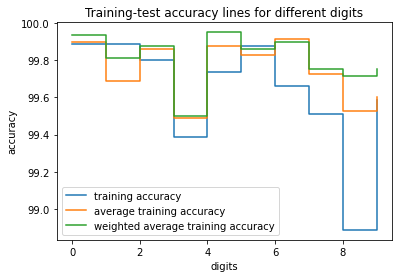

In [114]:
sum_graph = df_tr.plot(title = 'Training-test accuracy lines for different digits', xlabel = 'digits', ylabel = 'accuracy', drawstyle = 'steps-post')
sum_graph

In [115]:
df = pd.DataFrame(np.array([min_tr_test_acc,avg_test_acc,weighted_avg_test_acc]).T,
              columns = ['"min training error" test accuracy','average test accuracy','weighted average test accuracy'],
                 index = list(np.arange(10)))
df

,"""min training error"" test accuracy",average test accuracy,weighted average test accuracy
0,99.70,99.55,99.40
1,99.50,99.40,99.40
2,98.30,98.60,98.65
3,98.35,98.75,98.75
4,98.45,98.55,98.65
5,98.90,99.00,98.85
6,98.40,98.65,98.65
7,98.00,98.20,98.20
8,97.10,97.65,97.75
9,97.45,97.95,97.95


<AxesSubplot:title={'center':'Training-test accuracy lines for different digits'}, xlabel='digits', ylabel='accuracy'>

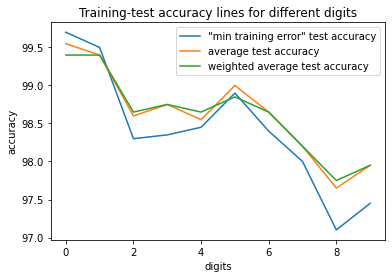

In [116]:
new_graph = df.plot(title = 'Training-test accuracy lines for different digits', xlabel = 'digits', ylabel = 'accuracy')
new_graph

# SECOND EXERCISE: MAKING PREDICTIONS AND TUNING HYPERPARAMETERS

### DEFINING FUNCTIONS

In [117]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


def kern(x1,x2,d=2,c=1):
    pre = c + np.dot(x1.T,x2)
    ret = pre**d
    return ret

def mapps(array):
    return ([kern(array[k][:-1],array[row_index][:-1]) for row_index in range(len(array)) for k in range(len(array))])

def splits(array,n_examples):
    return([array[i:i+n_examples] for i in range(0,n_examples**2,n_examples)])

def mapps_2(array,d):
    map = np.array([[None]*len(array)]*len(array))
    for row_index in range(len(array)):
        for k in range(row_index,len(array)):
                value = kern(array[k][:-1],array[row_index][:-1],d)
                map[row_index][k] = value
                map[k][row_index] = value
    return np.matrix(map)  

### Mapps_2 faster than mapps/split, they perform the same task.
# Mapps_2 possible only because the kernel matrices are symmetric ----> Mercer's theorem

def predict_test(train,test,alpha, row_index,d):
    activation = 0
    for k in range(len(train)):
        activation += alpha[k]*kern(train[k][:-1],test[row_index][:-1],d)  
    return (1.0 if activation >= 0.0 else -1.0,activation)

def predict_2(array,alpha, row_index, kernels):
    activation = np.dot(kernels[row_index],alpha)
    return 1.0 if activation >= 0.0 else -1.0

def train_kern_alpha(train, n_epoch, kernels): #train --> dataset to train
    alpha_list = []
    alpha = np.array([0.0 for i in range(len(train))])
    n_errors = []
    for epoch in range(n_epoch):
        sum_error = 0.0
        for i in range(len(train)):
            prediction = predict_2(train, alpha, i, kernels)
            error = (train[i][-1] - prediction)/2
            sum_error += error**2
            alpha[i] += error
        print('>epoch=%d, error=%.3f' % (epoch, sum_error))
        c = list(alpha).copy()
        n_errors.append(sum_error)
        alpha_list.append(c)
    print('average error = %2f' % (sum(n_errors)/len(n_errors)))    
    return (alpha,alpha_list,n_errors)

# train_kern_alpha(xtrainsmall,8)
# type(kern(xtrainsmall[0],xtrainsmall[1])) == np.float64 #True

def kernel_perceptron(train, test, n_epoch, kernels,d):
    predictions_tr = list()
    predictions_test = list()
    activations = []
    alpha,alpha_list,errors = train_kern_alpha(train, n_epoch, kernels)
    print(alpha)
    for row in range(len(train)):
        prediction = predict_2(train,alpha,row,kernels)
        predictions_tr.append(prediction)
    for row in range(len(test)):
        prediction, active = predict_test(train,test,alpha,row,d)
        predictions_test.append(prediction)
        activations.append(active)
    return(predictions_tr,predictions_test,alpha_list,errors,activations)

def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

def alpha_avg(alpha_list):
    avg = []
    for i in range(len(alpha_list[0])):
        count = 0
        for l in range(len(alpha_list)):
            count += alpha_list[l][i]
        avg.append(count/len(alpha_list))
    return avg

def weight_avg(alpha_list, scaled_n_err):
    avg = []
    for i in range(len(alpha_list[0])):
        count = 0
        for l in range(len(alpha_list)):
            count += alpha_list[l][i]*scaled_n_err[l]
        avg.append(count)
    return avg

def scaling(n_err):
    scaling = []
    for i in n_err:
        if i == 0:
            scaling.append(i)
        else:    
            scaling.append(1/i)
    scaled = []
    for el in scaling:
        scaled.append(el/sum(scaling))
    return scaled 

In [118]:
var_grid = [{'n_epochs':range(5,15,3)},{'degree_pol': range(2,8)}]

In [119]:
xtrain = np.array(onehot_digit0.iloc[:48000,:])
xtest = np.array(onehot_digit0.iloc[48000:,:])
xtrainsmall_train = xtrain[:6400]
xvalsmall = xtrain[6400:8000]

In [120]:
# It works faster !!!

def mapps_kernels(train, var_grid):
    mapkern = {}
    for deg in var_grid[1]['degree_pol']:
        kern = mapps_2(train, deg)
        mapkern[deg] = kern
    return mapkern    


def validation(train, test, var_grid, mapkern):
    initial_activations = []
    variables_accuracy = []
    for deg in var_grid[1]['degree_pol']:
        deg_accuracy = {}
        activations = []
        for epoch in var_grid[0]['n_epochs']:
            predicted_tr,predicted_test,alpha_list,err,activated = kernel_perceptron(train,test, epoch, mapkern[deg],deg)
            actual = [row[-1] for row in test]
            acc = accuracy_metric(actual, predicted_test)
            print('ploynomial_degree=%.3f, epoch=%d, accuracy=%.2f ' % (deg, epoch, acc))
            deg_accuracy[(deg, epoch)] = acc
            activations.append(activated)
        variables_accuracy.append(deg_accuracy)
        initial_activations.append(activations)
    return (variables_accuracy,initial_activations)   

def preparing_plot(validated):
    index = []
    for i in range(len(validated)):
        index.append(list(validated[i].keys())[0][0])
    epoch = []
    for l in range(len(validated[0])):
        epoch.append(list(validated[0].keys())[l][1])   
    accuracies = []
    for d in range(len(validated)):   
        accuracies.append(list(validated[d].values()))
    return(index, epoch, accuracies)   

def selection(performances,accumulator):
    select = {}
    for i in performances:
        for l in i:
            if i[l] == max(list(i.values())):
                select[l] = max(list(i.values()))
    max_acc = {}
    for l in select:
        if select[l] == max(list(select.values())):
            max_acc[l] = max(list(select.values()))

    list_epoch = []
    for el in list(max_acc.keys()):    
        list_epoch.append(el[1])
    list_deg = []
    last_sel = {}
    for es in max_acc:
        if es[1] == min(list_epoch):
            last_sel[es] = list(max_acc.values())[0]
    list_deg = []
    for el in list(last_sel.keys()):    
        list_deg.append(el[0])
    for es in last_sel:
        if es[0] == min(list_deg):
            accumulator.append((es,list(last_sel.values())[0]))

In [121]:
mapkern = mapps_kernels(xtrainsmall_train, var_grid)
validated_accuracies,active0 = validation(xtrainsmall_train, xvalsmall, var_grid, mapkern) 

>epoch=0, error=120.000
>epoch=1, error=31.000
>epoch=2, error=23.000
>epoch=3, error=22.000
>epoch=4, error=14.000
average error = 42.000000
[-1.  1. -1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=98.88 
>epoch=0, error=120.000
>epoch=1, error=31.000
>epoch=2, error=23.000
>epoch=3, error=22.000
>epoch=4, error=14.000
>epoch=5, error=10.000
>epoch=6, error=12.000
>epoch=7, error=8.000
average error = 30.000000
[-1.  1. -1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=8, accuracy=99.19 
>epoch=0, error=120.000
>epoch=1, error=31.000
>epoch=2, error=23.000
>epoch=3, error=22.000
>epoch=4, error=14.000
>epoch=5, error=10.000
>epoch=6, error=12.000
>epoch=7, error=8.000
>epoch=8, error=5.000
>epoch=9, error=5.000
>epoch=10, error=2.000
average error = 22.909091
[-1.  1. -1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=11, accuracy=99.56 
>epoch=0, error=120.000
>epoch=1, error=31.000
>epoch=2, error=23.000
>epoch=3, error=22.000
>epoch=4, error=14.000
>epoch=5, erro

In [122]:
selected_param = [] 
prev = []

In [123]:
validated_accuracies

[{(2, 5): 98.875, (2, 8): 99.1875, (2, 11): 99.5625, (2, 14): 99.5625},
 {(3, 5): 99.0, (3, 8): 98.9375, (3, 11): 98.9375, (3, 14): 98.9375},
 {(4, 5): 99.375, (4, 8): 99.375, (4, 11): 99.375, (4, 14): 99.375},
 {(5, 5): 99.5625, (5, 8): 99.5625, (5, 11): 99.5625, (5, 14): 99.5625},
 {(6, 5): 99.375, (6, 8): 99.375, (6, 11): 99.375, (6, 14): 99.375},
 {(7, 5): 99.0625, (7, 8): 99.0625, (7, 11): 99.0625, (7, 14): 99.0625}]

In [124]:
prev.append(active0)

In [125]:
selection(validated_accuracies, selected_param)

In [126]:
validated_accuracies[0]

{(2, 5): 98.875, (2, 8): 99.1875, (2, 11): 99.5625, (2, 14): 99.5625}

In [127]:
prepared = preparing_plot(validated_accuracies)
prepared

([2, 3, 4, 5, 6, 7],
 [5, 8, 11, 14],
 [[98.875, 99.1875, 99.5625, 99.5625],
  [99.0, 98.9375, 98.9375, 98.9375],
  [99.375, 99.375, 99.375, 99.375],
  [99.5625, 99.5625, 99.5625, 99.5625],
  [99.375, 99.375, 99.375, 99.375],
  [99.0625, 99.0625, 99.0625, 99.0625]])

In [128]:
df = pd.DataFrame(prepared[2],
                 columns = prepared[1],
                 index = prepared[0])
df

,5,8,11,14
2,98.8750,99.1875,99.5625,99.5625
3,99.0000,98.9375,98.9375,98.9375
4,99.3750,99.3750,99.3750,99.3750
5,99.5625,99.5625,99.5625,99.5625
6,99.3750,99.3750,99.3750,99.3750
7,99.0625,99.0625,99.0625,99.0625


In [129]:
def reorder(prepared):
    list_big = []
    for i in range(len(prepared[2][0])):
        list_zero = []
        for l in range(len(prepared[2])):
            list_zero.append(prepared[2][l][i])
        list_big.append(list_zero)
    return list_big

reorded0 = list(prepared)
reorded0[2] = reorder(prepared)
reorded0


[[2, 3, 4, 5, 6, 7],
 [5, 8, 11, 14],
 [[98.875, 99.0, 99.375, 99.5625, 99.375, 99.0625],
  [99.1875, 98.9375, 99.375, 99.5625, 99.375, 99.0625],
  [99.5625, 98.9375, 99.375, 99.5625, 99.375, 99.0625],
  [99.5625, 98.9375, 99.375, 99.5625, 99.375, 99.0625]]]

In [130]:
df1 = pd.DataFrame(reorded0[2],
                 columns = reorded0[0],
                 index = reorded0[1])
df1

,2,3,4,5,6,7
5,98.8750,99.0000,99.375,99.5625,99.375,99.0625
8,99.1875,98.9375,99.375,99.5625,99.375,99.0625
11,99.5625,98.9375,99.375,99.5625,99.375,99.0625
14,99.5625,98.9375,99.375,99.5625,99.375,99.0625


<AxesSubplot:title={'center':'Test accuracy lines for different epochs'}, xlabel='polynomial degree', ylabel='test accuracy'>

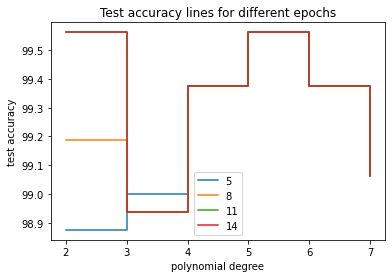

In [131]:
graph0 = df.plot(title = 'Test accuracy lines for different epochs', xlabel = 'polynomial degree', ylabel = 'test accuracy', drawstyle = 'steps-post')
graph0

<AxesSubplot:title={'center':'Test accuracy lines for polynomial degrees'}, xlabel='number of epochs', ylabel='test accuracy'>

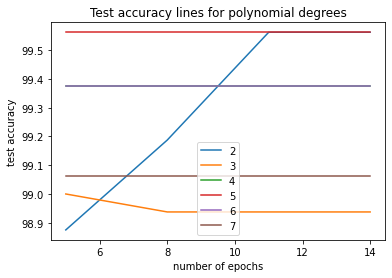

In [132]:
graph0_1 = df1.plot(title = 'Test accuracy lines for polynomial degrees', xlabel = 'number of epochs', ylabel = 'test accuracy')
graph0_1

## DIGIT 1 ANALYSIS

In [133]:
xtrain = np.array(onehot_digit1.iloc[:48000,:])
xtest = np.array(onehot_digit1.iloc[48000:,:])
xtrainsmall_train = xtrain[:6400]
xvalsmall = xtrain[6400:8000]
validated_accuracies,active1 = validation(xtrainsmall_train, xvalsmall, var_grid, mapkern)

>epoch=0, error=98.000
>epoch=1, error=60.000
>epoch=2, error=29.000
>epoch=3, error=22.000
>epoch=4, error=17.000
average error = 45.200000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=99.00 
>epoch=0, error=98.000
>epoch=1, error=60.000
>epoch=2, error=29.000
>epoch=3, error=22.000
>epoch=4, error=17.000
>epoch=5, error=13.000
>epoch=6, error=13.000
>epoch=7, error=11.000
average error = 32.875000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=8, accuracy=98.56 
>epoch=0, error=98.000
>epoch=1, error=60.000
>epoch=2, error=29.000
>epoch=3, error=22.000
>epoch=4, error=17.000
>epoch=5, error=13.000
>epoch=6, error=13.000
>epoch=7, error=11.000
>epoch=8, error=14.000
>epoch=9, error=1.000
>epoch=10, error=0.000
average error = 25.272727
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=11, accuracy=99.19 
>epoch=0, error=98.000
>epoch=1, error=60.000
>epoch=2, error=29.000
>epoch=3, error=22.000
>epoch=4, error=17.000
>epoch=5, error

In [134]:
prev.append(active1)

In [135]:
selection(validated_accuracies, selected_param)

In [136]:
selected_param

[((5, 5), 99.5625), ((4, 5), 99.5625)]

        5        8        11       14
2  99.0000  98.5625  99.1875  99.1875
3  99.3750  99.3750  99.3750  99.3750
4  99.5625  99.5625  99.5625  99.5625
5  99.3750  99.3750  99.3750  99.3750
6  99.4375  99.4375  99.4375  99.4375
7  99.3125  99.3125  99.3125  99.3125


<AxesSubplot:title={'center':'Test accuracy lines for different epochs'}, xlabel='polynomial degree', ylabel='test accuracy'>

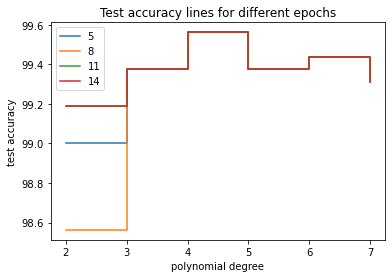

In [137]:
prepared = preparing_plot(validated_accuracies)
df = pd.DataFrame(prepared[2],
                 columns = prepared[1],
                  index = prepared[0])
print(df)
graph1 = df.plot(title = 'Test accuracy lines for different epochs', xlabel = 'polynomial degree', ylabel = 'test accuracy', drawstyle = 'steps-post')
graph1

          2       3        4       5        6        7
5   99.0000  99.375  99.5625  99.375  99.4375  99.3125
8   98.5625  99.375  99.5625  99.375  99.4375  99.3125
11  99.1875  99.375  99.5625  99.375  99.4375  99.3125
14  99.1875  99.375  99.5625  99.375  99.4375  99.3125


<AxesSubplot:title={'center':'Test accuracy lines for polynomial degrees'}, xlabel='number of epochs', ylabel='test accuracy'>

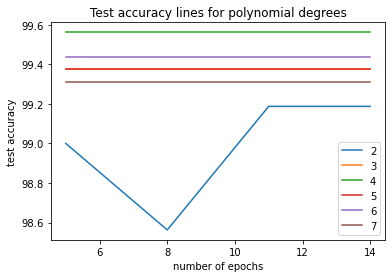

In [138]:
reorded1 = list(prepared)
reorded1[2] = reorder(prepared)
df1_1 = pd.DataFrame(reorded1[2],
                 columns = reorded1[0],
                 index = reorded1[1])
print(df1_1)
graph1_1 = df1_1.plot(title = 'Test accuracy lines for polynomial degrees', xlabel = 'number of epochs', ylabel = 'test accuracy')
graph1_1

### DIGIT 2 ANALYSIS

In [139]:
xtrain = np.array(onehot_digit2.iloc[:48000,:])
xtest = np.array(onehot_digit2.iloc[48000:,:])
xtrainsmall_train = xtrain[:6400]
xvalsmall = xtest[6400:8000]
validated_accuracies,active2 = validation(xtrainsmall_train, xvalsmall, var_grid, mapkern)

>epoch=0, error=224.000
>epoch=1, error=88.000
>epoch=2, error=46.000
>epoch=3, error=28.000
>epoch=4, error=25.000
average error = 82.200000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=98.69 
>epoch=0, error=224.000
>epoch=1, error=88.000
>epoch=2, error=46.000
>epoch=3, error=28.000
>epoch=4, error=25.000
>epoch=5, error=9.000
>epoch=6, error=10.000
>epoch=7, error=6.000
average error = 54.500000
[-1.  0. -1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=8, accuracy=98.75 
>epoch=0, error=224.000
>epoch=1, error=88.000
>epoch=2, error=46.000
>epoch=3, error=28.000
>epoch=4, error=25.000
>epoch=5, error=9.000
>epoch=6, error=10.000
>epoch=7, error=6.000
>epoch=8, error=3.000
>epoch=9, error=8.000
>epoch=10, error=2.000
average error = 40.818182
[-1.  0. -1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=11, accuracy=99.00 
>epoch=0, error=224.000
>epoch=1, error=88.000
>epoch=2, error=46.000
>epoch=3, error=28.000
>epoch=4, error=25.000
>epoch=5, error=

In [140]:
prev.append(active2)

In [141]:
selection(validated_accuracies, selected_param)

        5        8        11       14
2  98.6875  98.7500  99.0000  99.0000
3  97.5000  98.9375  98.9375  98.9375
4  98.7500  98.9375  98.9375  98.9375
5  99.0000  99.0000  99.0000  99.0000
6  98.6875  98.6875  98.6875  98.6875
7  98.6250  98.6250  98.6250  98.6250


<AxesSubplot:title={'center':'Test accuracy lines for different epochs'}, xlabel='polynomial degree', ylabel='test accuracy'>

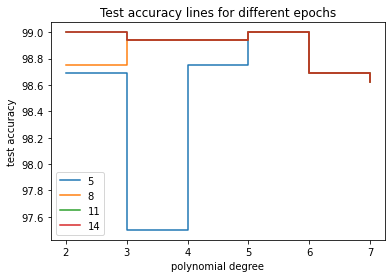

In [142]:
prepared = preparing_plot(validated_accuracies)
df = pd.DataFrame(prepared[2],
                 columns = prepared[1],
                  index = prepared[0])
print(df)
graph2 = df.plot(title = 'Test accuracy lines for different epochs', xlabel = 'polynomial degree', ylabel = 'test accuracy', drawstyle = 'steps-post')
graph2

          2        3        4     5        6       7
5   98.6875  97.5000  98.7500  99.0  98.6875  98.625
8   98.7500  98.9375  98.9375  99.0  98.6875  98.625
11  99.0000  98.9375  98.9375  99.0  98.6875  98.625
14  99.0000  98.9375  98.9375  99.0  98.6875  98.625


<AxesSubplot:title={'center':'Test accuracy lines for polynomial degrees'}, xlabel='number of epochs', ylabel='test accuracy'>

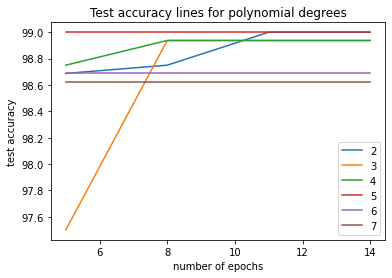

In [143]:
reorded2 = list(prepared)
reorded2[2] = reorder(prepared)
df2_1 = pd.DataFrame(reorded2[2],
                 columns = reorded2[0],
                 index = reorded2[1])
print(df2_1)
graph2_1 = df2_1.plot(title = 'Test accuracy lines for polynomial degrees', xlabel = 'number of epochs', ylabel = 'test accuracy')
graph2_1

### DIGIT 3 ANALYSIS

In [144]:
xtrain = np.array(onehot_digit3.iloc[:48000,:])
xtest = np.array(onehot_digit3.iloc[48000:,:])
xtrainsmall_train = xtrain[:6400]
xvalsmall = xtrain[6400:8000]
validated_accuracies,active3 = validation(xtrainsmall_train, xvalsmall, var_grid, mapkern)

>epoch=0, error=233.000
>epoch=1, error=102.000
>epoch=2, error=52.000
>epoch=3, error=50.000
>epoch=4, error=39.000
average error = 95.200000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=97.50 
>epoch=0, error=233.000
>epoch=1, error=102.000
>epoch=2, error=52.000
>epoch=3, error=50.000
>epoch=4, error=39.000
>epoch=5, error=21.000
>epoch=6, error=9.000
>epoch=7, error=9.000
average error = 64.375000
[-2.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=8, accuracy=98.00 
>epoch=0, error=233.000
>epoch=1, error=102.000
>epoch=2, error=52.000
>epoch=3, error=50.000
>epoch=4, error=39.000
>epoch=5, error=21.000
>epoch=6, error=9.000
>epoch=7, error=9.000
>epoch=8, error=3.000
>epoch=9, error=7.000
>epoch=10, error=2.000
average error = 47.909091
[-2.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=11, accuracy=97.19 
>epoch=0, error=233.000
>epoch=1, error=102.000
>epoch=2, error=52.000
>epoch=3, error=50.000
>epoch=4, error=39.000
>epoch=5, er

In [145]:
prev.append(active3)

In [146]:
selection(validated_accuracies, selected_param)

       5        8        11       14
2  97.500  98.0000  97.1875  98.1250
3  98.125  98.0625  98.0625  98.0625
4  98.125  98.1250  98.1250  98.1250
5  98.250  98.4375  98.4375  98.4375
6  98.375  97.8125  97.8125  97.8125
7  98.250  98.2500  98.2500  98.2500


<AxesSubplot:title={'center':'Test accuracy lines for different epochs'}, xlabel='polynomial degree', ylabel='test accuracy'>

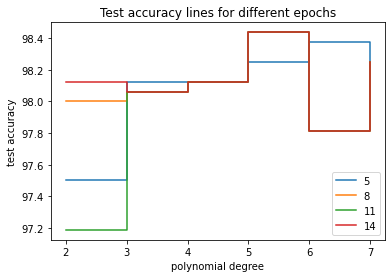

In [147]:
prepared = preparing_plot(validated_accuracies)
df = pd.DataFrame(prepared[2],
                 columns = prepared[1],
                  index = prepared[0])
print(df)
graph3 = df.plot(title = 'Test accuracy lines for different epochs', xlabel = 'polynomial degree', ylabel = 'test accuracy', drawstyle = 'steps-post')
graph3

          2        3       4        5        6      7
5   97.5000  98.1250  98.125  98.2500  98.3750  98.25
8   98.0000  98.0625  98.125  98.4375  97.8125  98.25
11  97.1875  98.0625  98.125  98.4375  97.8125  98.25
14  98.1250  98.0625  98.125  98.4375  97.8125  98.25


<AxesSubplot:title={'center':'Test accuracy lines for polynomial degrees'}, xlabel='number of epochs', ylabel='test accuracy'>

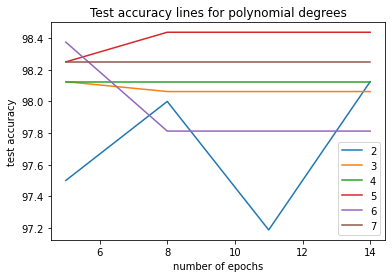

In [148]:
reorded3 = list(prepared)
reorded3[2] = reorder(prepared)
df3_1 = pd.DataFrame(reorded3[2],
                 columns = reorded3[0],
                 index = reorded3[1])
print(df3_1)
graph3_1 = df3_1.plot(title = 'Test accuracy lines for polynomial degrees', xlabel = 'number of epochs', ylabel = 'test accuracy')
graph3_1

### DIGIT 4 ANALYSIS

In [149]:
xtrain = np.array(onehot_digit4.iloc[:48000,:])
xtest = np.array(onehot_digit4.iloc[48000:,:])
xtrainsmall_train = xtrain[:6400]
xvalsmall = xtrain[6400:8000]
validated_accuracies,active4 = validation(xtrainsmall_train, xvalsmall, var_grid, mapkern)

>epoch=0, error=198.000
>epoch=1, error=65.000
>epoch=2, error=34.000
>epoch=3, error=38.000
>epoch=4, error=17.000
average error = 70.400000
[-1.  0.  1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=98.88 
>epoch=0, error=198.000
>epoch=1, error=65.000
>epoch=2, error=34.000
>epoch=3, error=38.000
>epoch=4, error=17.000
>epoch=5, error=4.000
>epoch=6, error=3.000
>epoch=7, error=9.000
average error = 46.000000
[-1.  0.  1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=8, accuracy=99.00 
>epoch=0, error=198.000
>epoch=1, error=65.000
>epoch=2, error=34.000
>epoch=3, error=38.000
>epoch=4, error=17.000
>epoch=5, error=4.000
>epoch=6, error=3.000
>epoch=7, error=9.000
>epoch=8, error=7.000
>epoch=9, error=7.000
>epoch=10, error=7.000
average error = 35.363636
[-1.  0.  1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=11, accuracy=98.88 
>epoch=0, error=198.000
>epoch=1, error=65.000
>epoch=2, error=34.000
>epoch=3, error=38.000
>epoch=4, error=17.000
>epoch=5, error=4.

In [150]:
prev.append(active4)

In [151]:
selection(validated_accuracies, selected_param)

        5        8        11       14
2  98.8750  99.0000  98.8750  98.7500
3  98.6875  98.7500  98.8750  98.8750
4  98.8125  98.8125  98.8125  98.8125
5  99.0000  99.0000  99.0000  99.0000
6  98.9375  98.9375  98.9375  98.9375
7  98.6250  98.6250  98.6250  98.6250


<AxesSubplot:title={'center':'Test accuracy lines for different epochs'}, xlabel='polynomial degree', ylabel='test accuracy'>

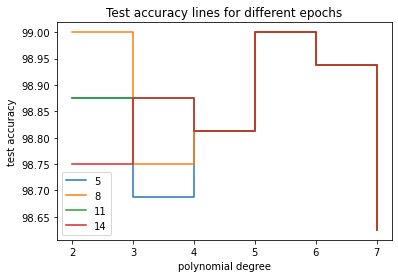

In [152]:
prepared = preparing_plot(validated_accuracies)
df = pd.DataFrame(prepared[2],
                 columns = prepared[1],
                  index = prepared[0])
print(df)
graph4 = df.plot(title = 'Test accuracy lines for different epochs', xlabel = 'polynomial degree', ylabel = 'test accuracy', drawstyle = 'steps-post')
graph4

         2        3        4     5        6       7
5   98.875  98.6875  98.8125  99.0  98.9375  98.625
8   99.000  98.7500  98.8125  99.0  98.9375  98.625
11  98.875  98.8750  98.8125  99.0  98.9375  98.625
14  98.750  98.8750  98.8125  99.0  98.9375  98.625


<AxesSubplot:title={'center':'Test accuracy lines for polynomial degrees'}, xlabel='number of epochs', ylabel='test accuracy'>

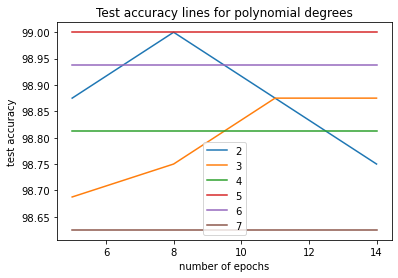

In [153]:
reorded4 = list(prepared)
reorded4[2] = reorder(prepared)
df4_1 = pd.DataFrame(reorded4[2],
                 columns = reorded4[0],
                 index = reorded4[1])
print(df4_1)
graph4_1 = df4_1.plot(title = 'Test accuracy lines for polynomial degrees', xlabel = 'number of epochs', ylabel = 'test accuracy')
graph4_1

### DIGIT 5 ANALYSIS

In [154]:
xtrain = np.array(onehot_digit5.iloc[:48000,:])
xtest = np.array(onehot_digit5.iloc[48000:,:])
xtrainsmall_train = xtrain[:6400]
xvalsmall = xtrain[6400:8000]
validated_accuracies,active5 = validation(xtrainsmall_train, xvalsmall, var_grid, mapkern)

>epoch=0, error=214.000
>epoch=1, error=63.000
>epoch=2, error=67.000
>epoch=3, error=41.000
>epoch=4, error=24.000
average error = 81.800000
[ 0. -1.  0. ...  0.  0.  1.]
ploynomial_degree=2.000, epoch=5, accuracy=98.50 
>epoch=0, error=214.000
>epoch=1, error=63.000
>epoch=2, error=67.000
>epoch=3, error=41.000
>epoch=4, error=24.000
>epoch=5, error=16.000
>epoch=6, error=20.000
>epoch=7, error=11.000
average error = 57.000000
[ 0. -1.  0. ...  0.  0.  1.]
ploynomial_degree=2.000, epoch=8, accuracy=98.69 
>epoch=0, error=214.000
>epoch=1, error=63.000
>epoch=2, error=67.000
>epoch=3, error=41.000
>epoch=4, error=24.000
>epoch=5, error=16.000
>epoch=6, error=20.000
>epoch=7, error=11.000
>epoch=8, error=3.000
>epoch=9, error=2.000
>epoch=10, error=5.000
average error = 42.363636
[ 0. -1.  0. ...  0.  0.  1.]
ploynomial_degree=2.000, epoch=11, accuracy=98.81 
>epoch=0, error=214.000
>epoch=1, error=63.000
>epoch=2, error=67.000
>epoch=3, error=41.000
>epoch=4, error=24.000
>epoch=5, er

In [155]:
prev.append(active5)

In [156]:
selection(validated_accuracies, selected_param)

        5        8        11       14
2  98.5000  98.6875  98.8125  98.8750
3  98.6875  98.7500  98.7500  98.7500
4  98.8125  98.8125  98.8125  98.8125
5  98.8125  98.7500  98.7500  98.7500
6  98.8750  98.8750  98.8750  98.8750
7  98.3125  98.3125  98.3125  98.3125


<AxesSubplot:title={'center':'Test accuracy lines for different epochs'}, xlabel='polynomial degree', ylabel='test accuracy'>

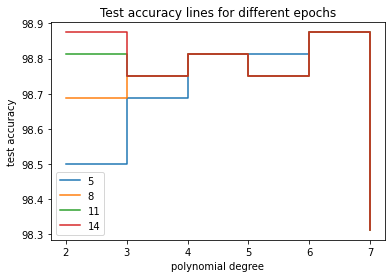

In [157]:
prepared = preparing_plot(validated_accuracies)
df = pd.DataFrame(prepared[2],
                 columns = prepared[1],
                  index = prepared[0])
print(df)
graph5 = df.plot(title = 'Test accuracy lines for different epochs', xlabel = 'polynomial degree', ylabel = 'test accuracy', drawstyle = 'steps-post')
graph5

          2        3        4        5       6        7
5   98.5000  98.6875  98.8125  98.8125  98.875  98.3125
8   98.6875  98.7500  98.8125  98.7500  98.875  98.3125
11  98.8125  98.7500  98.8125  98.7500  98.875  98.3125
14  98.8750  98.7500  98.8125  98.7500  98.875  98.3125


<AxesSubplot:title={'center':'Test accuracy lines for polynomial degrees'}, xlabel='number of epochs', ylabel='test accuracy'>

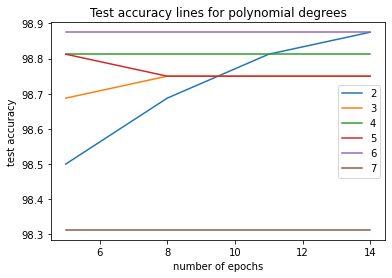

In [158]:
reorded5 = list(prepared)
reorded5[2] = reorder(prepared)
df5_1 = pd.DataFrame(reorded5[2],
                 columns = reorded5[0],
                 index = reorded5[1])
print(df5_1)
graph5_1 = df5_1.plot(title = 'Test accuracy lines for polynomial degrees', xlabel = 'number of epochs', ylabel = 'test accuracy')
graph5_1

### DIGIT 6 ANALYSIS

In [159]:
xtrain = np.array(onehot_digit6.iloc[:48000,:])
xtest = np.array(onehot_digit6.iloc[48000:,:])
xtrainsmall_train = xtrain[:6400]
xvalsmall = xtrain[6400:8000]
validated_accuracies,active6 = validation(xtrainsmall_train, xvalsmall, var_grid, mapkern)

>epoch=0, error=143.000
>epoch=1, error=77.000
>epoch=2, error=30.000
>epoch=3, error=11.000
>epoch=4, error=2.000
average error = 52.600000
[-1.  0.  0. ...  0.  0. -2.]
ploynomial_degree=2.000, epoch=5, accuracy=99.50 
>epoch=0, error=143.000
>epoch=1, error=77.000
>epoch=2, error=30.000
>epoch=3, error=11.000
>epoch=4, error=2.000
>epoch=5, error=15.000
>epoch=6, error=9.000
>epoch=7, error=8.000
average error = 36.875000
[-1.  0.  0. ...  0.  0. -2.]
ploynomial_degree=2.000, epoch=8, accuracy=99.12 
>epoch=0, error=143.000
>epoch=1, error=77.000
>epoch=2, error=30.000
>epoch=3, error=11.000
>epoch=4, error=2.000
>epoch=5, error=15.000
>epoch=6, error=9.000
>epoch=7, error=8.000
>epoch=8, error=5.000
>epoch=9, error=3.000
>epoch=10, error=0.000
average error = 27.545455
[-1.  0.  0. ...  0.  0. -2.]
ploynomial_degree=2.000, epoch=11, accuracy=99.31 
>epoch=0, error=143.000
>epoch=1, error=77.000
>epoch=2, error=30.000
>epoch=3, error=11.000
>epoch=4, error=2.000
>epoch=5, error=15.0

In [160]:
prev.append(active6)

In [161]:
selection(validated_accuracies, selected_param)

        5        8        11       14
2  99.5000  99.1250  99.3125  99.3125
3  99.6875  99.6875  99.6875  99.6875
4  99.2500  99.2500  99.2500  99.2500
5  99.3750  99.3750  99.3750  99.3750
6  99.4375  99.4375  99.4375  99.4375
7  99.3125  99.3125  99.3125  99.3125


<AxesSubplot:title={'center':'Test accuracy lines for different epochs'}, xlabel='polynomial degree', ylabel='test accuracy'>

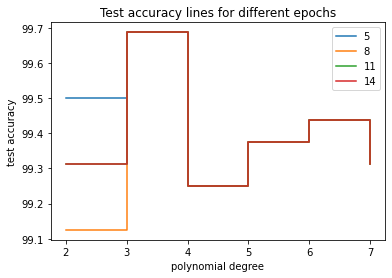

In [162]:
prepared = preparing_plot(validated_accuracies)
df = pd.DataFrame(prepared[2],
                 columns = prepared[1],
                  index = prepared[0])
print(df)
graph6 = df.plot(title = 'Test accuracy lines for different epochs', xlabel = 'polynomial degree', ylabel = 'test accuracy', drawstyle = 'steps-post')
graph6

          2        3      4       5        6        7
5   99.5000  99.6875  99.25  99.375  99.4375  99.3125
8   99.1250  99.6875  99.25  99.375  99.4375  99.3125
11  99.3125  99.6875  99.25  99.375  99.4375  99.3125
14  99.3125  99.6875  99.25  99.375  99.4375  99.3125


<AxesSubplot:title={'center':'Test accuracy lines for polynomial degrees'}, xlabel='number of epochs', ylabel='test accuracy'>

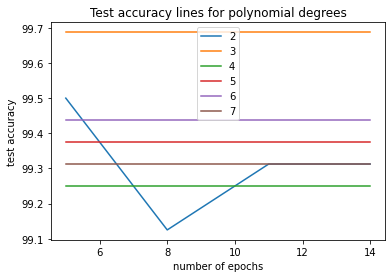

In [163]:
reorded6 = list(prepared)
reorded6[2] = reorder(prepared)
df6_1 = pd.DataFrame(reorded6[2],
                 columns = reorded6[0],
                 index = reorded6[1])
print(df6_1)
graph6_1 = df6_1.plot(title = 'Test accuracy lines for polynomial degrees', xlabel = 'number of epochs', ylabel = 'test accuracy')
graph6_1

### DIGIT 7 ANALYSIS

In [164]:
xtrain = np.array(onehot_digit7.iloc[:48000,:])
xtest = np.array(onehot_digit7.iloc[48000:,:])
xtrainsmall_train = xtrain[:6400]
xvalsmall = xtrain[6400:8000]
validated_accuracies,active7 = validation(xtrainsmall_train, xvalsmall, var_grid, mapkern)

>epoch=0, error=183.000
>epoch=1, error=96.000
>epoch=2, error=57.000
>epoch=3, error=42.000
>epoch=4, error=42.000
average error = 84.000000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=98.56 
>epoch=0, error=183.000
>epoch=1, error=96.000
>epoch=2, error=57.000
>epoch=3, error=42.000
>epoch=4, error=42.000
>epoch=5, error=19.000
>epoch=6, error=19.000
>epoch=7, error=21.000
average error = 59.875000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=8, accuracy=98.56 
>epoch=0, error=183.000
>epoch=1, error=96.000
>epoch=2, error=57.000
>epoch=3, error=42.000
>epoch=4, error=42.000
>epoch=5, error=19.000
>epoch=6, error=19.000
>epoch=7, error=21.000
>epoch=8, error=15.000
>epoch=9, error=10.000
>epoch=10, error=8.000
average error = 46.545455
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=11, accuracy=95.44 
>epoch=0, error=183.000
>epoch=1, error=96.000
>epoch=2, error=57.000
>epoch=3, error=42.000
>epoch=4, error=42.000
>epoch=5, 

In [165]:
prev.append(active7)

In [166]:
selection(validated_accuracies, selected_param)

        5        8        11       14
2  98.5625  98.5625  95.4375  99.1250
3  99.1875  99.1875  99.1875  99.1875
4  99.0625  99.0625  99.0625  99.0625
5  98.9375  98.9375  98.9375  98.9375
6  98.9375  98.9375  98.9375  98.9375
7  98.9375  98.9375  98.9375  98.9375


<AxesSubplot:title={'center':'Test accuracy lines for different epochs'}, xlabel='polynomial degree', ylabel='test accuracy'>

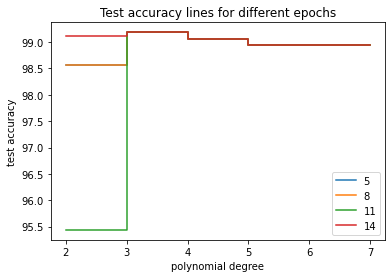

In [167]:
prepared = preparing_plot(validated_accuracies)
df = pd.DataFrame(prepared[2],
                 columns = prepared[1],
                  index = prepared[0])
print(df)
graph7 = df.plot(title = 'Test accuracy lines for different epochs', xlabel = 'polynomial degree', ylabel = 'test accuracy', drawstyle = 'steps-post')
graph7

          2        3        4        5        6        7
5   98.5625  99.1875  99.0625  98.9375  98.9375  98.9375
8   98.5625  99.1875  99.0625  98.9375  98.9375  98.9375
11  95.4375  99.1875  99.0625  98.9375  98.9375  98.9375
14  99.1250  99.1875  99.0625  98.9375  98.9375  98.9375


<AxesSubplot:title={'center':'Test accuracy lines for polynomial degrees'}, xlabel='number of epochs', ylabel='test accuracy'>

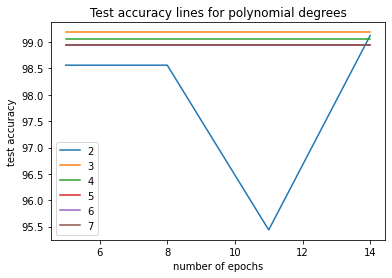

In [168]:
reorded7 = list(prepared)
reorded7[2] = reorder(prepared)
df7_1 = pd.DataFrame(reorded7[2],
                 columns = reorded7[0],
                 index = reorded7[1])
print(df7_1)
graph7_1 = df7_1.plot(title = 'Test accuracy lines for polynomial degrees', xlabel = 'number of epochs', ylabel = 'test accuracy')
graph7_1

### DIGIT 8 ANALYSIS

In [169]:
xtrain = np.array(onehot_digit8.iloc[:48000,:])
xtest = np.array(onehot_digit8.iloc[48000:,:])
xtrainsmall_train = xtrain[:6400]
xvalsmall = xtrain[6400:8000]
validated_accuracies,active8 = validation(xtrainsmall_train, xvalsmall, var_grid, mapkern)

>epoch=0, error=324.000
>epoch=1, error=122.000
>epoch=2, error=91.000
>epoch=3, error=60.000
>epoch=4, error=37.000
average error = 126.800000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=97.75 
>epoch=0, error=324.000
>epoch=1, error=122.000
>epoch=2, error=91.000
>epoch=3, error=60.000
>epoch=4, error=37.000
>epoch=5, error=31.000
>epoch=6, error=16.000
>epoch=7, error=34.000
average error = 89.375000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=8, accuracy=97.88 
>epoch=0, error=324.000
>epoch=1, error=122.000
>epoch=2, error=91.000
>epoch=3, error=60.000
>epoch=4, error=37.000
>epoch=5, error=31.000
>epoch=6, error=16.000
>epoch=7, error=34.000
>epoch=8, error=26.000
>epoch=9, error=11.000
>epoch=10, error=3.000
average error = 68.636364
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=11, accuracy=97.81 
>epoch=0, error=324.000
>epoch=1, error=122.000
>epoch=2, error=91.000
>epoch=3, error=60.000
>epoch=4, error=37.000
>epoc

In [170]:
prev.append(active8)

In [171]:
selection(validated_accuracies, selected_param)

        5        8        11       14
2  97.7500  97.8750  97.8125  97.7500
3  98.0000  98.1875  98.1875  98.1875
4  98.1875  98.0625  98.0625  98.0625
5  98.0625  98.0625  98.0625  98.0625
6  97.8125  97.8125  97.8125  97.8125
7  97.5625  97.5625  97.5625  97.5625


<AxesSubplot:title={'center':'Test accuracy lines for different epochs'}, xlabel='polynomial degree', ylabel='test accuracy'>

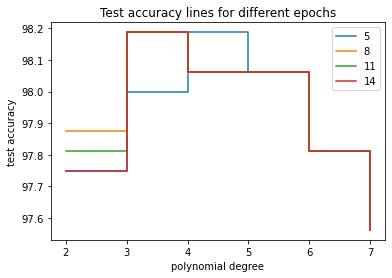

In [172]:
prepared = preparing_plot(validated_accuracies)
df = pd.DataFrame(prepared[2],
                 columns = prepared[1],
                  index = prepared[0])
print(df)
graph8 = df.plot(title = 'Test accuracy lines for different epochs', xlabel = 'polynomial degree', ylabel = 'test accuracy', drawstyle = 'steps-post')
graph8

          2        3        4        5        6        7
5   97.7500  98.0000  98.1875  98.0625  97.8125  97.5625
8   97.8750  98.1875  98.0625  98.0625  97.8125  97.5625
11  97.8125  98.1875  98.0625  98.0625  97.8125  97.5625
14  97.7500  98.1875  98.0625  98.0625  97.8125  97.5625


<AxesSubplot:title={'center':'Test accuracy lines for polynomial degrees'}, xlabel='number of epochs', ylabel='test accuracy'>

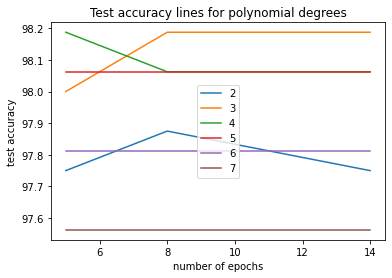

In [173]:
reorded8 = list(prepared)
reorded8[2] = reorder(prepared)
df8_1 = pd.DataFrame(reorded8[2],
                 columns = reorded8[0],
                 index = reorded8[1])
print(df8_1)
graph8_1 = df8_1.plot(title = 'Test accuracy lines for polynomial degrees', xlabel = 'number of epochs', ylabel = 'test accuracy')
graph8_1

### DIGIT 9 ANALYSIS

In [174]:
xtrain = np.array(onehot_digit9.iloc[:48000,:])
xtest = np.array(onehot_digit9.iloc[48000:,:])
xtrainsmall_train = xtrain[:6400]
xvalsmall = xtrain[6400:8000]
validated_accuracies,active9 = validation(xtrainsmall_train, xvalsmall, var_grid, mapkern)

>epoch=0, error=326.000
>epoch=1, error=151.000
>epoch=2, error=115.000
>epoch=3, error=85.000
>epoch=4, error=56.000
average error = 146.600000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=97.69 
>epoch=0, error=326.000
>epoch=1, error=151.000
>epoch=2, error=115.000
>epoch=3, error=85.000
>epoch=4, error=56.000
>epoch=5, error=35.000
>epoch=6, error=27.000
>epoch=7, error=28.000
average error = 102.875000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=8, accuracy=98.44 
>epoch=0, error=326.000
>epoch=1, error=151.000
>epoch=2, error=115.000
>epoch=3, error=85.000
>epoch=4, error=56.000
>epoch=5, error=35.000
>epoch=6, error=27.000
>epoch=7, error=28.000
>epoch=8, error=26.000
>epoch=9, error=18.000
>epoch=10, error=12.000
average error = 79.909091
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=11, accuracy=98.19 
>epoch=0, error=326.000
>epoch=1, error=151.000
>epoch=2, error=115.000
>epoch=3, error=85.000
>epoch=4, error=56.000

In [175]:
prev.append(active9)

In [176]:
selection(validated_accuracies, selected_param)

        5        8        11       14
2  97.6875  98.4375  98.1875  98.3750
3  98.3125  98.1875  98.5625  98.5625
4  98.3750  98.6875  98.8125  98.8125
5  98.6250  98.6250  98.6250  98.6250
6  98.3750  98.3750  98.3750  98.3750
7  98.1875  98.1875  98.1875  98.1875


<AxesSubplot:title={'center':'Test accuracy lines for different epochs'}, xlabel='polynomial degree', ylabel='test accuracy'>

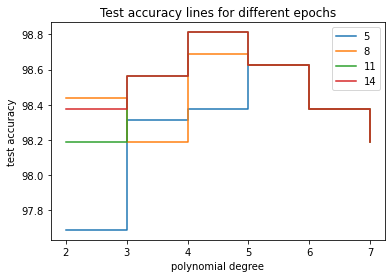

In [177]:
prepared = preparing_plot(validated_accuracies)
df = pd.DataFrame(prepared[2],
                 columns = prepared[1],
                  index = prepared[0])
print(df)
graph9 = df.plot(title = 'Test accuracy lines for different epochs', xlabel = 'polynomial degree', ylabel = 'test accuracy', drawstyle = 'steps-post')
graph9

          2        3        4       5       6        7
5   97.6875  98.3125  98.3750  98.625  98.375  98.1875
8   98.4375  98.1875  98.6875  98.625  98.375  98.1875
11  98.1875  98.5625  98.8125  98.625  98.375  98.1875
14  98.3750  98.5625  98.8125  98.625  98.375  98.1875


<AxesSubplot:title={'center':'Test accuracy lines for polynomial degrees'}, xlabel='polynomial degree', ylabel='test accuracy'>

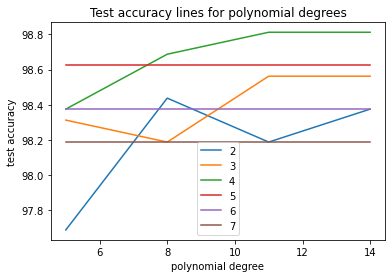

In [178]:
reorded9 = list(prepared)
reorded9[2] = reorder(prepared)
df9_1 = pd.DataFrame(reorded9[2],
                 columns = reorded9[0],
                 index = reorded9[1])
print(df9_1)
graph9_1 = df9_1.plot(title = 'Test accuracy lines for polynomial degrees', xlabel = 'polynomial degree', ylabel = 'test accuracy')
graph9_1

In [179]:
selected_param

[((5, 5), 99.5625),
 ((4, 5), 99.5625),
 ((5, 5), 99.0),
 ((5, 8), 98.4375),
 ((5, 5), 99.0),
 ((6, 5), 98.875),
 ((3, 5), 99.6875),
 ((3, 5), 99.1875),
 ((4, 5), 98.1875),
 ((4, 11), 98.8125)]

### SUM UP OF "TUNING HYPERPARAMETERS"

Here the couple of hyperparameters (polynomial degree, number of epochs) which guarantees the best test accuracy on the validation set is reported for each binary classifier corresponding to different digits.

In [180]:
for i in range(len(selected_param)):
    print(' polynomial degree =%d and epochs =%d guarantee %.2f accuracy in the validation set for digit %d' % (selected_param[i][0][0], selected_param[i][0][1],selected_param[i][1],i))

 polynomial degree =5 and epochs =5 guarantee 99.56 accuracy in the validation set for digit 0
 polynomial degree =4 and epochs =5 guarantee 99.56 accuracy in the validation set for digit 1
 polynomial degree =5 and epochs =5 guarantee 99.00 accuracy in the validation set for digit 2
 polynomial degree =5 and epochs =8 guarantee 98.44 accuracy in the validation set for digit 3
 polynomial degree =5 and epochs =5 guarantee 99.00 accuracy in the validation set for digit 4
 polynomial degree =6 and epochs =5 guarantee 98.88 accuracy in the validation set for digit 5
 polynomial degree =3 and epochs =5 guarantee 99.69 accuracy in the validation set for digit 6
 polynomial degree =3 and epochs =5 guarantee 99.19 accuracy in the validation set for digit 7
 polynomial degree =4 and epochs =5 guarantee 98.19 accuracy in the validation set for digit 8
 polynomial degree =4 and epochs =11 guarantee 98.81 accuracy in the validation set for digit 9


## TUNING WITH CROSS VALIDATION

In [181]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


def kern(x1,x2,d=2,c=1):
    pre = c + np.dot(x1.T,x2)
    ret = pre**d
    return ret

def mapps(array):
    return ([kern(array[k][:-1],array[row_index][:-1]) for row_index in range(len(array)) for k in range(len(array))])

def splits(array,n_examples):
    return([array[i:i+n_examples] for i in range(0,n_examples**2,n_examples)])

def mapps_2(array,d):
    map = np.array([[None]*len(array)]*len(array))
    for row_index in range(len(array)):
        for k in range(row_index,len(array)):
                value = kern(array[k][:-1],array[row_index][:-1],d)
                map[row_index][k] = value
                map[k][row_index] = value
    return np.matrix(map)  

### Mapps_2 faster than mapps/split, they perform the same task.
# Mapps_2 possible only because the kernel matrices are symmetric ----> Mercer's theorem

def predict_test(train,test,alpha, row_index,d):
    activation = 0
    for k in range(len(train)):
        activation += alpha[k]*kern(train[k][:-1],test[row_index][:-1],d)  
    return 1.0 if activation >= 0.0 else -1.0

def predict_2(array,alpha, row_index, kernels):
    activation = np.dot(kernels[row_index],alpha)
    return 1.0 if activation >= 0.0 else -1.0

def train_kern_alpha(train, n_epoch, kernels): #train --> dataset to train
    alpha_list = []
    alpha = np.array([0.0 for i in range(len(train))])
    n_errors = []
    for epoch in range(n_epoch):
        sum_error = 0.0
        for i in range(len(train)):
            prediction = predict_2(train, alpha, i, kernels)
            error = (train[i][-1] - prediction)/2
            sum_error += error**2
            alpha[i] += error
        print('>epoch=%d, error=%.3f' % (epoch, sum_error))
        c = list(alpha).copy()
        n_errors.append(sum_error)
        alpha_list.append(c)
    print('average error = %2f' % (sum(n_errors)/len(n_errors)))    
    return (alpha,alpha_list,n_errors)

# train_kern_alpha(xtrainsmall,8)
# type(kern(xtrainsmall[0],xtrainsmall[1])) == np.float64 #True

def kernel_perceptron(train, test, n_epoch, kernels,d):
    predictions_tr = list()
    predictions_test = list()
    activations = []
    alpha,alpha_list,errors = train_kern_alpha(train, n_epoch, kernels)
    print(alpha)
    for row in range(len(train)):
        prediction = predict_2(train,alpha,row,kernels)
        predictions_tr.append(prediction)
    for row in range(len(test)):
        prediction = predict_test(train,test,alpha,row,d)
        predictions_test.append(prediction)
    return(predictions_tr,predictions_test,alpha_list,errors)

def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

def alpha_avg(alpha_list):
    avg = []
    for i in range(len(alpha_list[0])):
        count = 0
        for l in range(len(alpha_list)):
            count += alpha_list[l][i]
        avg.append(count/len(alpha_list))
    return avg

def weight_avg(alpha_list, scaled_n_err):
    avg = []
    for i in range(len(alpha_list[0])):
        count = 0
        for l in range(len(alpha_list)):
            count += alpha_list[l][i]*scaled_n_err[l]
        avg.append(count)
    return avg

def scaling(n_err):
    scaling = []
    for i in n_err:
        if i == 0:
            scaling.append(i)
        else:    
            scaling.append(1/i)
    scaled = []
    for el in scaling:
        scaled.append(el/sum(scaling))
    return scaled 

In [182]:
def cross_validation_performance(train, var_grid, blocks):
    variables_accuracy = []
    for deg in var_grid[1]['degree_pol']:
        deg_accuracy = {}
        for epoch in var_grid[0]['n_epochs']:
            block_perf = []
            for i in range(blocks):
                new_train = np.array(train[:i*len(train)//blocks].tolist() + train[(i+1)*len(train)//blocks:].tolist())
                test = train[i*len(train)//blocks:(i+1)*len(train)//blocks]
                pred_tr,predicted,a_list,err = kernel_perceptron(new_train,test, epoch, mapps_2(new_train,deg),deg)
                actual = [row[-1] for row in test]
                acc = accuracy_metric(actual, predicted)
                block_perf.append(acc) 
            print('ploynomial_degree=%.3f, epoch=%d, accuracy=%.2f ' % (deg, epoch, sum(block_perf)/len(block_perf)))
            deg_accuracy[(deg, epoch)] = sum(block_perf)/len(block_perf)
            variables_accuracy.append(deg_accuracy)
    return variables_accuracy    

def selection(performances,accumulator):
    select = {}
    for i in performances:
        for l in i:
            if i[l] == max(list(i.values())):
                select[l] = max(list(i.values()))
    max_acc = {}
    for l in select:
        if select[l] == max(list(select.values())):
            max_acc[l] = max(list(select.values()))

    list_epoch = []
    for el in list(max_acc.keys()):    
        list_epoch.append(el[1])
    list_deg = []
    last_sel = {}
    for es in max_acc:
        if es[1] == min(list_epoch):
            last_sel[es] = list(max_acc.values())[0]
    list_deg = []
    for el in list(last_sel.keys()):    
        list_deg.append(el[0])
    for es in last_sel:
        if es[0] == min(list_deg):
            accumulator.append((es,list(last_sel.values())[0]))

In [183]:
cross_selected_param = []
var_grid = [{'n_epochs':range(5,15,3)},{'degree_pol': range(2,8)}]

### DIGIT 0

In [184]:
xtrain = np.array(onehot_digit0.iloc[:48000,:])
xtrainsmall_train = xtrain[:8000]
cross_validated_accuracies = cross_validation_performance(xtrainsmall_train, var_grid, 5)

>epoch=0, error=122.000
>epoch=1, error=34.000
>epoch=2, error=25.000
>epoch=3, error=20.000
>epoch=4, error=8.000
average error = 41.800000
[ 1. -1.  0. ...  0.  0.  0.]
>epoch=0, error=133.000
>epoch=1, error=40.000
>epoch=2, error=34.000
>epoch=3, error=12.000
>epoch=4, error=13.000
average error = 46.400000
[-1.  1. -1. ...  0.  0.  0.]
>epoch=0, error=117.000
>epoch=1, error=46.000
>epoch=2, error=19.000
>epoch=3, error=20.000
>epoch=4, error=25.000
average error = 45.400000
[-1.  1. -1. ...  0.  0.  0.]
>epoch=0, error=130.000
>epoch=1, error=42.000
>epoch=2, error=21.000
>epoch=3, error=21.000
>epoch=4, error=14.000
average error = 45.600000
[-1.  1. -1. ...  0.  0.  0.]
>epoch=0, error=120.000
>epoch=1, error=31.000
>epoch=2, error=23.000
>epoch=3, error=22.000
>epoch=4, error=14.000
average error = 42.000000
[-1.  1. -1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=99.22 
>epoch=0, error=122.000
>epoch=1, error=34.000
>epoch=2, error=25.000
>epoch=3, error=20.00

In [185]:
selection(cross_validated_accuracies, cross_selected_param)

In [186]:
cross_selected_param

[((2, 14), 99.525)]

### DIGIT 1

In [187]:
xtrain = np.array(onehot_digit1.iloc[:48000,:])
xtrainsmall_train = xtrain[:8000]
cross_validated_accuracies = cross_validation_performance(xtrainsmall_train, var_grid, 5)

>epoch=0, error=107.000
>epoch=1, error=43.000
>epoch=2, error=26.000
>epoch=3, error=24.000
>epoch=4, error=24.000
average error = 44.800000
[-1.  1.  0. ...  0.  0.  0.]
>epoch=0, error=116.000
>epoch=1, error=47.000
>epoch=2, error=38.000
>epoch=3, error=23.000
>epoch=4, error=30.000
average error = 50.800000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=107.000
>epoch=1, error=52.000
>epoch=2, error=27.000
>epoch=3, error=25.000
>epoch=4, error=15.000
average error = 45.200000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=105.000
>epoch=1, error=60.000
>epoch=2, error=41.000
>epoch=3, error=26.000
>epoch=4, error=21.000
average error = 50.600000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=98.000
>epoch=1, error=60.000
>epoch=2, error=29.000
>epoch=3, error=22.000
>epoch=4, error=17.000
average error = 45.200000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=99.12 
>epoch=0, error=107.000
>epoch=1, error=43.000
>epoch=2, error=26.000
>epoch=3, error=24.00

In [188]:
selection(cross_validated_accuracies, cross_selected_param)

### DIGIT 2

In [189]:
xtrain = np.array(onehot_digit2.iloc[:48000,:])
xtrainsmall_train = xtrain[:8000]
cross_validated_accuracies = cross_validation_performance(xtrainsmall_train, var_grid, 5)

>epoch=0, error=200.000
>epoch=1, error=61.000
>epoch=2, error=60.000
>epoch=3, error=34.000
>epoch=4, error=24.000
average error = 75.800000
[-1.  0.  1. ...  0.  0.  0.]
>epoch=0, error=225.000
>epoch=1, error=94.000
>epoch=2, error=45.000
>epoch=3, error=41.000
>epoch=4, error=17.000
average error = 84.400000
[-1.  0. -1. ...  0.  0.  0.]
>epoch=0, error=201.000
>epoch=1, error=90.000
>epoch=2, error=45.000
>epoch=3, error=30.000
>epoch=4, error=28.000
average error = 78.800000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=223.000
>epoch=1, error=86.000
>epoch=2, error=41.000
>epoch=3, error=30.000
>epoch=4, error=25.000
average error = 81.000000
[-1.  0. -1. ...  0.  0.  0.]
>epoch=0, error=224.000
>epoch=1, error=88.000
>epoch=2, error=46.000
>epoch=3, error=28.000
>epoch=4, error=25.000
average error = 82.200000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=98.54 
>epoch=0, error=200.000
>epoch=1, error=61.000
>epoch=2, error=60.000
>epoch=3, error=34.0

In [190]:
selection(cross_validated_accuracies, cross_selected_param)

### DIGIT 3

In [191]:
xtrain = np.array(onehot_digit3.iloc[:48000,:])
xtrainsmall_train = xtrain[:8000]
cross_validated_accuracies = cross_validation_performance(xtrainsmall_train, var_grid, 5)

>epoch=0, error=243.000
>epoch=1, error=105.000
>epoch=2, error=75.000
>epoch=3, error=45.000
>epoch=4, error=37.000
average error = 101.000000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=244.000
>epoch=1, error=93.000
>epoch=2, error=72.000
>epoch=3, error=46.000
>epoch=4, error=32.000
average error = 97.400000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=243.000
>epoch=1, error=109.000
>epoch=2, error=79.000
>epoch=3, error=55.000
>epoch=4, error=37.000
average error = 104.600000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=240.000
>epoch=1, error=97.000
>epoch=2, error=89.000
>epoch=3, error=45.000
>epoch=4, error=41.000
average error = 102.400000
[-1.  0.  0. ...  0. -1.  0.]
>epoch=0, error=233.000
>epoch=1, error=102.000
>epoch=2, error=52.000
>epoch=3, error=50.000
>epoch=4, error=39.000
average error = 95.200000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=98.11 
>epoch=0, error=243.000
>epoch=1, error=105.000
>epoch=2, error=75.000
>epoch=3, err

In [192]:
selection(cross_validated_accuracies, cross_selected_param)

### DIGIT 4

In [193]:
xtrain = np.array(onehot_digit4.iloc[:48000,:])
xtrainsmall_train = xtrain[:8000]
cross_validated_accuracies = cross_validation_performance(xtrainsmall_train, var_grid, 5)

>epoch=0, error=196.000
>epoch=1, error=70.000
>epoch=2, error=35.000
>epoch=3, error=21.000
>epoch=4, error=15.000
average error = 67.400000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=191.000
>epoch=1, error=72.000
>epoch=2, error=37.000
>epoch=3, error=34.000
>epoch=4, error=31.000
average error = 73.000000
[-1.  0.  1. ...  0.  0.  0.]
>epoch=0, error=198.000
>epoch=1, error=62.000
>epoch=2, error=37.000
>epoch=3, error=26.000
>epoch=4, error=13.000
average error = 67.200000
[-1.  0.  1. ...  0.  0.  0.]
>epoch=0, error=202.000
>epoch=1, error=72.000
>epoch=2, error=44.000
>epoch=3, error=37.000
>epoch=4, error=19.000
average error = 74.800000
[-1.  0.  1. ...  0.  0.  0.]
>epoch=0, error=198.000
>epoch=1, error=65.000
>epoch=2, error=34.000
>epoch=3, error=38.000
>epoch=4, error=17.000
average error = 70.400000
[-1.  0.  1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=98.74 
>epoch=0, error=196.000
>epoch=1, error=70.000
>epoch=2, error=35.000
>epoch=3, error=21.0

In [194]:
selection(cross_validated_accuracies, cross_selected_param)

### DIGIT 5

In [195]:
xtrain = np.array(onehot_digit5.iloc[:48000,:])
xtrainsmall_train = xtrain[:8000]
cross_validated_accuracies = cross_validation_performance(xtrainsmall_train, var_grid, 5)

>epoch=0, error=221.000
>epoch=1, error=80.000
>epoch=2, error=42.000
>epoch=3, error=32.000
>epoch=4, error=13.000
average error = 77.600000
[-1.  0.  0. ... -1.  0.  0.]
>epoch=0, error=223.000
>epoch=1, error=89.000
>epoch=2, error=42.000
>epoch=3, error=33.000
>epoch=4, error=25.000
average error = 82.400000
[ 0. -1.  0. ...  0.  0.  0.]
>epoch=0, error=227.000
>epoch=1, error=98.000
>epoch=2, error=48.000
>epoch=3, error=26.000
>epoch=4, error=23.000
average error = 84.400000
[ 0. -1.  0. ...  0.  0.  0.]
>epoch=0, error=227.000
>epoch=1, error=74.000
>epoch=2, error=55.000
>epoch=3, error=26.000
>epoch=4, error=24.000
average error = 81.200000
[ 0. -1.  0. ...  0.  0.  0.]
>epoch=0, error=214.000
>epoch=1, error=63.000
>epoch=2, error=67.000
>epoch=3, error=41.000
>epoch=4, error=24.000
average error = 81.800000
[ 0. -1.  0. ...  0.  0.  1.]
ploynomial_degree=2.000, epoch=5, accuracy=98.72 
>epoch=0, error=221.000
>epoch=1, error=80.000
>epoch=2, error=42.000
>epoch=3, error=32.0

In [196]:
selection(cross_validated_accuracies, cross_selected_param)

### DIGIT 6

In [197]:
xtrain = np.array(onehot_digit6.iloc[:48000,:])
xtrainsmall_train = xtrain[:8000]
cross_validated_accuracies = cross_validation_performance(xtrainsmall_train, var_grid, 5)

>epoch=0, error=153.000
>epoch=1, error=51.000
>epoch=2, error=25.000
>epoch=3, error=37.000
>epoch=4, error=19.000
average error = 57.000000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=141.000
>epoch=1, error=63.000
>epoch=2, error=30.000
>epoch=3, error=16.000
>epoch=4, error=2.000
average error = 50.400000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=141.000
>epoch=1, error=52.000
>epoch=2, error=33.000
>epoch=3, error=23.000
>epoch=4, error=19.000
average error = 53.600000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=138.000
>epoch=1, error=67.000
>epoch=2, error=33.000
>epoch=3, error=15.000
>epoch=4, error=14.000
average error = 53.400000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=143.000
>epoch=1, error=77.000
>epoch=2, error=30.000
>epoch=3, error=11.000
>epoch=4, error=2.000
average error = 52.600000
[-1.  0.  0. ...  0.  0. -2.]
ploynomial_degree=2.000, epoch=5, accuracy=99.15 
>epoch=0, error=153.000
>epoch=1, error=51.000
>epoch=2, error=25.000
>epoch=3, error=37.000

In [198]:
selection(cross_validated_accuracies, cross_selected_param)

### DIGIT 7

In [199]:
xtrain = np.array(onehot_digit7.iloc[:48000,:])
xtrainsmall_train = xtrain[:8000]
cross_validated_accuracies = cross_validation_performance(xtrainsmall_train, var_grid, 5)

>epoch=0, error=168.000
>epoch=1, error=83.000
>epoch=2, error=45.000
>epoch=3, error=34.000
>epoch=4, error=27.000
average error = 71.400000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=181.000
>epoch=1, error=97.000
>epoch=2, error=46.000
>epoch=3, error=34.000
>epoch=4, error=26.000
average error = 76.800000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=186.000
>epoch=1, error=67.000
>epoch=2, error=53.000
>epoch=3, error=50.000
>epoch=4, error=22.000
average error = 75.600000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=186.000
>epoch=1, error=91.000
>epoch=2, error=43.000
>epoch=3, error=35.000
>epoch=4, error=22.000
average error = 75.400000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=183.000
>epoch=1, error=96.000
>epoch=2, error=57.000
>epoch=3, error=42.000
>epoch=4, error=42.000
average error = 84.000000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=98.76 
>epoch=0, error=168.000
>epoch=1, error=83.000
>epoch=2, error=45.000
>epoch=3, error=34.0

In [200]:
selection(cross_validated_accuracies, cross_selected_param)

### DIGIT 8

In [201]:
xtrain = np.array(onehot_digit8.iloc[:48000,:])
xtrainsmall_train = xtrain[:8000]
cross_validated_accuracies = cross_validation_performance(xtrainsmall_train, var_grid, 5)

>epoch=0, error=352.000
>epoch=1, error=133.000
>epoch=2, error=90.000
>epoch=3, error=64.000
>epoch=4, error=36.000
average error = 135.000000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=336.000
>epoch=1, error=140.000
>epoch=2, error=79.000
>epoch=3, error=83.000
>epoch=4, error=39.000
average error = 135.400000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=324.000
>epoch=1, error=149.000
>epoch=2, error=94.000
>epoch=3, error=55.000
>epoch=4, error=51.000
average error = 134.600000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=333.000
>epoch=1, error=144.000
>epoch=2, error=68.000
>epoch=3, error=57.000
>epoch=4, error=33.000
average error = 127.000000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=324.000
>epoch=1, error=122.000
>epoch=2, error=91.000
>epoch=3, error=60.000
>epoch=4, error=37.000
average error = 126.800000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=98.15 
>epoch=0, error=352.000
>epoch=1, error=133.000
>epoch=2, error=90.000
>epoch=3,

In [202]:
selection(cross_validated_accuracies, cross_selected_param)

### DIGIT 9

In [203]:
xtrain = np.array(onehot_digit9.iloc[:48000,:])
xtrainsmall_train = xtrain[:8000]
cross_validated_accuracies = cross_validation_performance(xtrainsmall_train, var_grid, 5)

>epoch=0, error=303.000
>epoch=1, error=156.000
>epoch=2, error=100.000
>epoch=3, error=58.000
>epoch=4, error=52.000
average error = 133.800000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=337.000
>epoch=1, error=177.000
>epoch=2, error=82.000
>epoch=3, error=80.000
>epoch=4, error=39.000
average error = 143.000000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=321.000
>epoch=1, error=146.000
>epoch=2, error=101.000
>epoch=3, error=85.000
>epoch=4, error=36.000
average error = 137.800000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=330.000
>epoch=1, error=161.000
>epoch=2, error=97.000
>epoch=3, error=82.000
>epoch=4, error=57.000
average error = 145.400000
[-1.  0.  0. ...  0.  0.  0.]
>epoch=0, error=326.000
>epoch=1, error=151.000
>epoch=2, error=115.000
>epoch=3, error=85.000
>epoch=4, error=56.000
average error = 146.600000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=97.99 
>epoch=0, error=303.000
>epoch=1, error=156.000
>epoch=2, error=100.000
>epoc

In [204]:
selection(cross_validated_accuracies, cross_selected_param)

In [205]:
cross_selected_param

[((2, 14), 99.525),
 ((4, 8), 99.5125),
 ((4, 8), 98.925),
 ((3, 11), 98.7875),
 ((2, 8), 99.1),
 ((2, 14), 99.0625),
 ((3, 8), 99.4125),
 ((3, 8), 99.05),
 ((5, 11), 98.5625),
 ((5, 8), 98.5625)]

In [206]:
for i in range(len(cross_selected_param)):
    print(' polynomial degree =%d and epochs =%d guarantee %.2f accuracy in cross-validation for digit %d' % (cross_selected_param[i][0][0], cross_selected_param[i][0][1],cross_selected_param[i][1],i))

 polynomial degree =2 and epochs =14 guarantee 99.53 accuracy in cross-validation for digit 0
 polynomial degree =4 and epochs =8 guarantee 99.51 accuracy in cross-validation for digit 1
 polynomial degree =4 and epochs =8 guarantee 98.92 accuracy in cross-validation for digit 2
 polynomial degree =3 and epochs =11 guarantee 98.79 accuracy in cross-validation for digit 3
 polynomial degree =2 and epochs =8 guarantee 99.10 accuracy in cross-validation for digit 4
 polynomial degree =2 and epochs =14 guarantee 99.06 accuracy in cross-validation for digit 5
 polynomial degree =3 and epochs =8 guarantee 99.41 accuracy in cross-validation for digit 6
 polynomial degree =3 and epochs =8 guarantee 99.05 accuracy in cross-validation for digit 7
 polynomial degree =5 and epochs =11 guarantee 98.56 accuracy in cross-validation for digit 8
 polynomial degree =5 and epochs =8 guarantee 98.56 accuracy in cross-validation for digit 9


## TRAINING THE MODEL WITH TUNED HYPERPARAMETERS

In [207]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


def kern(x1,x2,d=2,c=1):
    pre = c + np.dot(x1.T,x2)
    ret = pre**d
    return ret

def mapps(array):
    return ([kern(array[k][:-1],array[row_index][:-1]) for row_index in range(len(array)) for k in range(len(array))])

def splits(array,n_examples):
    return([array[i:i+n_examples] for i in range(0,n_examples**2,n_examples)])

def mapps_2(array,d):
    map = np.array([[None]*len(array)]*len(array))
    for row_index in range(len(array)):
        for k in range(row_index,len(array)):
                value = kern(array[k][:-1],array[row_index][:-1],d)
                map[row_index][k] = value
                map[k][row_index] = value
    return np.matrix(map)  

### Mapps_2 faster than mapps/split, they perform the same task.
# Mapps_2 possible only because the kernel matrices are symmetric ----> Mercer's theorem

def predict_test(train,test,alpha, row_index,d):
    activation = 0
    for k in range(len(train)):
        activation += alpha[k]*kern(train[k][:-1],test[row_index][:-1],d)  
    return (1.0 if activation >= 0.0 else -1.0,activation)

def predict_2(array,alpha, row_index, kernels):
    activation = np.dot(kernels[row_index],alpha)
    return 1.0 if activation >= 0.0 else -1.0

def train_kern_alpha(train, n_epoch, kernels): #train --> dataset to train
    alpha_list = []
    alpha = np.array([0.0 for i in range(len(train))])
    n_errors = []
    for epoch in range(n_epoch):
        sum_error = 0.0
        for i in range(len(train)):
            prediction = predict_2(train, alpha, i, kernels)
            error = (train[i][-1] - prediction)/2
            sum_error += error**2
            alpha[i] += error
        print('>epoch=%d, error=%.3f' % (epoch, sum_error))
        c = list(alpha).copy()
        n_errors.append(sum_error)
        alpha_list.append(c)
    print('average error = %2f' % (sum(n_errors)/len(n_errors)))    
    return (alpha,alpha_list,n_errors)

# train_kern_alpha(xtrainsmall,8)
# type(kern(xtrainsmall[0],xtrainsmall[1])) == np.float64 #True

def kernel_perceptron(train, test, n_epoch, kernels,d):
    predictions_tr = list()
    predictions_test = list()
    activations = []
    alpha,alpha_list,errors = train_kern_alpha(train, n_epoch, kernels)
    print(alpha)
    for row in range(len(train)):
        prediction = predict_2(train,alpha,row,kernels)
        predictions_tr.append(prediction)
    for row in range(len(test)):
        prediction, active = predict_test(train,test,alpha,row,d)
        predictions_test.append(prediction)
        activations.append(active)
    return(predictions_tr,predictions_test,alpha_list,errors,activations)

def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

def alpha_avg(alpha_list):
    avg = []
    for i in range(len(alpha_list[0])):
        count = 0
        for l in range(len(alpha_list)):
            count += alpha_list[l][i]
        avg.append(count/len(alpha_list))
    return avg

def weight_avg(alpha_list, scaled_n_err):
    avg = []
    for i in range(len(alpha_list[0])):
        count = 0
        for l in range(len(alpha_list)):
            count += alpha_list[l][i]*scaled_n_err[l]
        avg.append(count)
    return avg

def scaling(n_err):
    scaling = []
    for i in n_err:
        if i == 0:
            scaling.append(i)
        else:    
            scaling.append(1/i)
    scaled = []
    for el in scaling:
        scaled.append(el/sum(scaling))
    return scaled 

### DIGIT 0 ANALYSIS

In [208]:
new_best_tr_acc = []
new_best_test_acc = []
best_weighted_avg = []
best_weighted_avg_test_acc = []
activations_report = []
weighted_activations_report = []
errors_collection = []
cross_errors_collection = []
cross_new_best_tr_acc = []
cross_new_best_test_acc = []
cross_best_weighted_avg = []
cross_best_weighted_avg_test_acc = []
cross_activations_report = []
cross_weighted_activations_report = []
selected_param

[((5, 5), 99.5625),
 ((4, 5), 99.5625),
 ((5, 5), 99.0),
 ((5, 8), 98.4375),
 ((5, 5), 99.0),
 ((6, 5), 98.875),
 ((3, 5), 99.6875),
 ((3, 5), 99.1875),
 ((4, 5), 98.1875),
 ((4, 11), 98.8125)]

In [209]:
# combining traing and validation set

xtrain = np.array(onehot_digit0)
xtest = np.array(onehot_digit0_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,selected_param[0][0][0])

In [210]:
predicted_tr,predicted_test,alpha_list,err0,activated0 = kernel_perceptron(train,test, selected_param[0][0][1], kernels, selected_param[0][0][0])
errors_collection.append(err0)
actual = [row[-1] for row in train]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
new_best_test_acc.append(accuracy_metric(actual, predicted_test))
activations_report.append(activated0)

>epoch=0, error=149.000
>epoch=1, error=23.000
>epoch=2, error=11.000
>epoch=3, error=12.000
>epoch=4, error=8.000
average error = 40.600000
[-1.  1. -1. ...  0.  0.  0.]
training accuracy = 99.99
test accuracy = 99.50


In [211]:
# weighted average training and test
weighted_averaged  = weight_avg(alpha_list,scaling(err0))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg.append(accuracy_metric(actual, group))

group = []
a_report0 = []
for row in range(len(test)):
        prediction, active = predict_test(train,test, weighted_averaged,row,selected_param[0][0][0])
        group.append(prediction)
        a_report0.append(active)
actual = [row[-1] for row in test]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
weighted_activations_report.append(a_report0)

weighted average training accuracy = 99.99
weighted average test accuracy = 99.65


#### CV-predictors

In [212]:
xtrain = np.array(onehot_digit0)
xtest = np.array(onehot_digit0_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,cross_selected_param[0][0][0])

In [213]:
predicted_tr,predicted_test,cross_alpha_list,cross_err0,cross_activated0 = kernel_perceptron(train,test, cross_selected_param[0][0][1], kernels, cross_selected_param[0][0][0])
cross_errors_collection.append(cross_err0)
actual = [row[-1] for row in train]
print('cross training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
cross_new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('cross test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
cross_new_best_test_acc.append(accuracy_metric(actual, predicted_test))
cross_activations_report.append(cross_activated0)

>epoch=0, error=141.000
>epoch=1, error=46.000
>epoch=2, error=35.000
>epoch=3, error=17.000
>epoch=4, error=23.000
>epoch=5, error=10.000
>epoch=6, error=15.000
>epoch=7, error=4.000
>epoch=8, error=0.000
>epoch=9, error=0.000
>epoch=10, error=0.000
>epoch=11, error=0.000
>epoch=12, error=0.000
>epoch=13, error=0.000
average error = 20.785714
[-1.  1. -1. ...  0.  0.  0.]
cross training accuracy = 100.00
cross test accuracy = 99.65


In [214]:
# weighted average training and test
weighted_averaged  = weight_avg(cross_alpha_list,scaling(cross_err0))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('cross weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg.append(accuracy_metric(actual, group))

group = []
cross_a_report0 = []
for row in range(len(test)):
        prediction, active = predict_test(train,test, weighted_averaged,row,cross_selected_param[0][0][0])
        group.append(prediction)
        cross_a_report0.append(active)
actual = [row[-1] for row in test]
print('cross weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
cross_weighted_activations_report.append(cross_a_report0)

cross weighted average training accuracy = 99.99
cross weighted average test accuracy = 99.60


### DIGIT 1 ANALYSIS

In [215]:
# combining traing and validation set

xtrain = np.array(onehot_digit1)
xtest = np.array(onehot_digit1_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,selected_param[1][0][0])

In [216]:
predicted_tr,predicted_test,alpha_list1,err1,activated1 = kernel_perceptron(train,test, selected_param[1][0][1], kernels, selected_param[1][0][0])
errors_collection.append(err1)
actual = [row[-1] for row in train]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
new_best_test_acc.append(accuracy_metric(actual, predicted_test))
activations_report.append(activated1)

>epoch=0, error=114.000
>epoch=1, error=24.000
>epoch=2, error=15.000
>epoch=3, error=22.000
>epoch=4, error=5.000
average error = 36.000000
[-1.  0.  0. ...  0.  0.  0.]
training accuracy = 99.99
test accuracy = 99.60


In [217]:
# weighted average training and test
weighted_averaged  = weight_avg(alpha_list1,scaling(err1))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg.append(accuracy_metric(actual, group))

group = []
a_report1 = []
for row in range(len(test)):
        prediction, active = predict_test(train,test, weighted_averaged,row,selected_param[1][0][0])
        group.append(prediction)
        a_report1.append(active)
actual = [row[-1] for row in test]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
weighted_activations_report.append(a_report1)

weighted average training accuracy = 100.00
weighted average test accuracy = 99.65


#### CV-predictors

In [218]:
xtrain = np.array(onehot_digit1)
xtest = np.array(onehot_digit1_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,cross_selected_param[1][0][0])

In [219]:
predicted_tr,predicted_test,cross_alpha_list1,cross_err1,cross_activated1 = kernel_perceptron(train,test, cross_selected_param[1][0][1], kernels, cross_selected_param[1][0][0])
cross_errors_collection.append(cross_err1)
actual = [row[-1] for row in train]
print('cross training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
cross_new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('cross test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
cross_new_best_test_acc.append(accuracy_metric(actual, predicted_test))
cross_activations_report.append(cross_activated1)

>epoch=0, error=114.000
>epoch=1, error=24.000
>epoch=2, error=15.000
>epoch=3, error=22.000
>epoch=4, error=5.000
>epoch=5, error=3.000
>epoch=6, error=1.000
>epoch=7, error=0.000
average error = 23.000000
[-1.  0.  0. ...  0.  0.  0.]
cross training accuracy = 100.00
cross test accuracy = 99.65


In [220]:
# weighted average training and test
weighted_averaged  = weight_avg(cross_alpha_list1,scaling(cross_err1))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('cross weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg.append(accuracy_metric(actual, group))

group = []
cross_a_report1 = []
for row in range(len(test)):
        prediction, active = predict_test(train,test, weighted_averaged,row,cross_selected_param[1][0][0])
        group.append(prediction)
        cross_a_report1.append(active)
actual = [row[-1] for row in test]
print('cross weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
cross_weighted_activations_report.append(cross_a_report1)

cross weighted average training accuracy = 100.00
cross weighted average test accuracy = 99.65


### DIGIT 2 ANALYSIS

In [221]:
# combining traing and validation set

xtrain = np.array(onehot_digit2)
xtest = np.array(onehot_digit2_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,selected_param[2][0][0])

In [222]:
predicted_tr,predicted_test,alpha_list2,err2,activated2 = kernel_perceptron(train,test, selected_param[2][0][1], kernels, selected_param[2][0][0])
errors_collection.append(err2)
actual = [row[-1] for row in train]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
new_best_test_acc.append(accuracy_metric(actual, predicted_test))
activations_report.append(activated2)

>epoch=0, error=229.000
>epoch=1, error=54.000
>epoch=2, error=15.000
>epoch=3, error=11.000
>epoch=4, error=11.000
average error = 64.000000
[-1.  0.  0. ...  0.  0.  0.]
training accuracy = 99.71
test accuracy = 98.20


In [223]:
# weighted average training and test
weighted_averaged  = weight_avg(alpha_list2,scaling(err2))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg.append(accuracy_metric(actual, group))

group = []
a_report2 = []
for row in range(len(test)):
        prediction,active = predict_test(train,test, weighted_averaged,row,selected_param[2][0][0])
        group.append(prediction)
        a_report2.append(active)
actual = [row[-1] for row in test]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
weighted_activations_report.append(a_report2)

weighted average training accuracy = 99.91
weighted average test accuracy = 98.45


#### CV-predictors

In [224]:
xtrain = np.array(onehot_digit2)
xtest = np.array(onehot_digit2_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,cross_selected_param[2][0][0])

In [225]:
predicted_tr,predicted_test,cross_alpha_list2,cross_err2,cross_activated2 = kernel_perceptron(train,test, cross_selected_param[2][0][1], kernels, cross_selected_param[2][0][0])
cross_errors_collection.append(cross_err2)
actual = [row[-1] for row in train]
print('cross training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
cross_new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('cross test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
cross_new_best_test_acc.append(accuracy_metric(actual, predicted_test))
cross_activations_report.append(cross_activated2)

>epoch=0, error=207.000
>epoch=1, error=53.000
>epoch=2, error=34.000
>epoch=3, error=26.000
>epoch=4, error=17.000
>epoch=5, error=6.000
>epoch=6, error=0.000
>epoch=7, error=0.000
average error = 42.875000
[-1.  0.  0. ...  0.  0.  0.]
cross training accuracy = 100.00
cross test accuracy = 98.80


In [226]:
# weighted average training and test
weighted_averaged  = weight_avg(cross_alpha_list2,scaling(cross_err2))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('cross weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg.append(accuracy_metric(actual, group))

group = []
cross_a_report2 = []
for row in range(len(test)):
        prediction, active = predict_test(train,test, weighted_averaged,row,cross_selected_param[2][0][0])
        group.append(prediction)
        cross_a_report2.append(active)
actual = [row[-1] for row in test]
print('cross weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
cross_weighted_activations_report.append(cross_a_report2)

cross weighted average training accuracy = 99.99
cross weighted average test accuracy = 98.80


### DIGIT 3 ANALYSIS

In [227]:
# combining traing and validation set

xtrain = np.array(onehot_digit3)
xtest = np.array(onehot_digit3_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,selected_param[3][0][0])

In [228]:
predicted_tr,predicted_test,alpha_list3,err3,activated3 = kernel_perceptron(train,test, selected_param[3][0][1], kernels, selected_param[3][0][0])
errors_collection.append(err3)
actual = [row[-1] for row in train]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
new_best_test_acc.append(accuracy_metric(actual, predicted_test))
activations_report.append(activated3)

>epoch=0, error=259.000
>epoch=1, error=44.000
>epoch=2, error=49.000
>epoch=3, error=28.000
>epoch=4, error=19.000
>epoch=5, error=7.000
>epoch=6, error=6.000
>epoch=7, error=3.000
average error = 51.875000
[-1.  0.  0. ...  0.  0.  0.]
training accuracy = 100.00
test accuracy = 98.90


In [229]:
# weighted average training and test
weighted_averaged  = weight_avg(alpha_list3,scaling(err3))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg.append(accuracy_metric(actual, group))

group = []
a_report3 = []
for row in range(len(test)):
        prediction,active = predict_test(train,test, weighted_averaged,row,selected_param[3][0][0])
        group.append(prediction)
        a_report3.append(active)
actual = [row[-1] for row in test]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
weighted_activations_report.append(a_report3)

weighted average training accuracy = 100.00
weighted average test accuracy = 98.85


#### CV-predictors

In [230]:
xtrain = np.array(onehot_digit3)
xtest = np.array(onehot_digit3_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,cross_selected_param[3][0][0])

In [231]:
predicted_tr,predicted_test,cross_alpha_list3,cross_err3,cross_activated3 = kernel_perceptron(train,test, cross_selected_param[3][0][1], kernels, cross_selected_param[3][0][0])
cross_errors_collection.append(cross_err3)
actual = [row[-1] for row in train]
print('cross training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
cross_new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('cross test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
cross_new_best_test_acc.append(accuracy_metric(actual, predicted_test))
cross_activations_report.append(cross_activated3)

>epoch=0, error=252.000
>epoch=1, error=78.000
>epoch=2, error=42.000
>epoch=3, error=34.000
>epoch=4, error=20.000
>epoch=5, error=9.000
>epoch=6, error=6.000
>epoch=7, error=6.000
>epoch=8, error=4.000
>epoch=9, error=2.000
>epoch=10, error=0.000
average error = 41.181818
[-1.  0.  0. ...  0.  0.  0.]
cross training accuracy = 100.00
cross test accuracy = 98.75


In [232]:
# weighted average training and test
weighted_averaged  = weight_avg(cross_alpha_list3,scaling(cross_err3))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('cross weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg.append(accuracy_metric(actual, group))

group = []
cross_a_report3 = []
for row in range(len(test)):
        prediction, active = predict_test(train,test, weighted_averaged,row,cross_selected_param[3][0][0])
        group.append(prediction)
        cross_a_report3.append(active)
actual = [row[-1] for row in test]
print('cross weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
cross_weighted_activations_report.append(cross_a_report3)

cross weighted average training accuracy = 100.00
cross weighted average test accuracy = 98.75


### DIGIT 4 ANALYSIS

In [233]:
# combining traing and validation set

xtrain = np.array(onehot_digit4)
xtest = np.array(onehot_digit4_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,selected_param[4][0][0])

In [234]:
predicted_tr,predicted_test,alpha_list4,err4,activated4 = kernel_perceptron(train,test, selected_param[4][0][1], kernels, selected_param[4][0][0])
errors_collection.append(err4)
actual = [row[-1] for row in train]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
new_best_test_acc.append(accuracy_metric(actual, predicted_test))
activations_report.append(activated4)

>epoch=0, error=203.000
>epoch=1, error=64.000
>epoch=2, error=29.000
>epoch=3, error=10.000
>epoch=4, error=2.000
average error = 61.600000
[-1.  0.  1. ...  0.  0.  0.]
training accuracy = 99.95
test accuracy = 98.05


In [235]:
# weighted average training and test
weighted_averaged  = weight_avg(alpha_list4,scaling(err4))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg.append(accuracy_metric(actual, group))

group = []
a_report4 = []
for row in range(len(test)):
        prediction,active = predict_test(train,test, weighted_averaged,row,selected_param[4][0][0])
        group.append(prediction)
        a_report4.append(active)
actual = [row[-1] for row in test]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
weighted_activations_report.append(a_report4)

weighted average training accuracy = 99.98
weighted average test accuracy = 98.30


#### CV-predictors

In [236]:
xtrain = np.array(onehot_digit4)
xtest = np.array(onehot_digit4_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,cross_selected_param[4][0][0])

In [237]:
predicted_tr,predicted_test,cross_alpha_list4,cross_err4,cross_activated4 = kernel_perceptron(train,test, cross_selected_param[4][0][1], kernels, cross_selected_param[4][0][0])
cross_errors_collection.append(cross_err4)
actual = [row[-1] for row in train]
print('cross training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
cross_new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('cross test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
cross_new_best_test_acc.append(accuracy_metric(actual, predicted_test))
cross_activations_report.append(cross_activated4)

>epoch=0, error=234.000
>epoch=1, error=78.000
>epoch=2, error=42.000
>epoch=3, error=22.000
>epoch=4, error=29.000
>epoch=5, error=14.000
>epoch=6, error=24.000
>epoch=7, error=8.000
average error = 56.375000
[-1.  0.  1. ...  0.  0.  0.]
cross training accuracy = 99.59
cross test accuracy = 98.45


In [238]:
# weighted average training and test
weighted_averaged  = weight_avg(cross_alpha_list4,scaling(cross_err4))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('cross weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg.append(accuracy_metric(actual, group))

group = []
cross_a_report4 = []
for row in range(len(test)):
        prediction, active = predict_test(train,test, weighted_averaged,row,cross_selected_param[4][0][0])
        group.append(prediction)
        cross_a_report4.append(active)
actual = [row[-1] for row in test]
print('cross weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
cross_weighted_activations_report.append(cross_a_report4)

cross weighted average training accuracy = 99.96
cross weighted average test accuracy = 98.95


### DIGIT 5 ANALYSIS

In [239]:
# combining traing and validation set

xtrain = np.array(onehot_digit5)
xtest = np.array(onehot_digit5_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,selected_param[5][0][0])

In [240]:
predicted_tr,predicted_test,alpha_list5,err5,activated5 = kernel_perceptron(train,test, selected_param[5][0][1], kernels, selected_param[5][0][0])
errors_collection.append(err5)
actual = [row[-1] for row in train]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
new_best_test_acc.append(accuracy_metric(actual, predicted_test))
activations_report.append(activated5)

>epoch=0, error=216.000
>epoch=1, error=48.000
>epoch=2, error=17.000
>epoch=3, error=6.000
>epoch=4, error=3.000
average error = 58.000000
[ 0. -1.  0. ...  0.  0.  0.]
training accuracy = 100.00
test accuracy = 98.95


In [241]:
# weighted average training and test
weighted_averaged  = weight_avg(alpha_list5,scaling(err5))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg.append(accuracy_metric(actual, group))

group = []
a_report5 = []
for row in range(len(test)):
        prediction,active = predict_test(train,test, weighted_averaged,row,selected_param[5][0][0])
        group.append(prediction)
        a_report5.append(active)
actual = [row[-1] for row in test]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
weighted_activations_report.append(a_report5)

weighted average training accuracy = 100.00
weighted average test accuracy = 98.90


#### CV-predictors

In [242]:
xtrain = np.array(onehot_digit5)
xtest = np.array(onehot_digit5_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,cross_selected_param[5][0][0])

In [243]:
predicted_tr,predicted_test,cross_alpha_list5,cross_err5,cross_activated5 = kernel_perceptron(train,test, cross_selected_param[5][0][1], kernels, cross_selected_param[5][0][0])
cross_errors_collection.append(cross_err5)
actual = [row[-1] for row in train]
print('cross training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
cross_new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('cross test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
cross_new_best_test_acc.append(accuracy_metric(actual, predicted_test))
cross_activations_report.append(cross_activated5)

>epoch=0, error=248.000
>epoch=1, error=100.000
>epoch=2, error=73.000
>epoch=3, error=39.000
>epoch=4, error=32.000
>epoch=5, error=21.000
>epoch=6, error=20.000
>epoch=7, error=13.000
>epoch=8, error=10.000
>epoch=9, error=5.000
>epoch=10, error=2.000
>epoch=11, error=0.000
>epoch=12, error=0.000
>epoch=13, error=0.000
average error = 40.214286
[ 0. -1.  0. ...  0.  0.  0.]
cross training accuracy = 100.00
cross test accuracy = 98.85


In [244]:
# weighted average training and test
weighted_averaged  = weight_avg(cross_alpha_list5,scaling(cross_err5))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('cross weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg.append(accuracy_metric(actual, group))

group = []
cross_a_report5 = []
for row in range(len(test)):
        prediction, active = predict_test(train,test, weighted_averaged,row,cross_selected_param[5][0][0])
        group.append(prediction)
        cross_a_report5.append(active)
actual = [row[-1] for row in test]
print('cross weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
cross_weighted_activations_report.append(cross_a_report5)

cross weighted average training accuracy = 100.00
cross weighted average test accuracy = 99.05


### DIGIT 6 ANALYSIS

In [245]:
# combining traing and validation set

xtrain = np.array(onehot_digit6)
xtest = np.array(onehot_digit6_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,selected_param[6][0][0])

In [246]:
predicted_tr,predicted_test,alpha_list6,err6,activated6 = kernel_perceptron(train,test, selected_param[6][0][1], kernels, selected_param[6][0][0])
errors_collection.append(err6)
actual = [row[-1] for row in train]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
new_best_test_acc.append(accuracy_metric(actual, predicted_test))
activations_report.append(activated6)

>epoch=0, error=150.000
>epoch=1, error=46.000
>epoch=2, error=22.000
>epoch=3, error=11.000
>epoch=4, error=11.000
average error = 48.000000
[-1.  0.  0. ...  0.  0.  0.]
training accuracy = 100.00
test accuracy = 98.95


In [247]:
# weighted average training and test
weighted_averaged  = weight_avg(alpha_list6,scaling(err6))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg.append(accuracy_metric(actual, group))

group = []
a_report6 = []
for row in range(len(test)):
        prediction,active = predict_test(train,test, weighted_averaged,row,selected_param[6][0][0])
        group.append(prediction)
        a_report6.append(active)
actual = [row[-1] for row in test]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
weighted_activations_report.append(a_report6)

weighted average training accuracy = 99.99
weighted average test accuracy = 98.95


#### CV-predictors

In [248]:
xtrain = np.array(onehot_digit6)
xtest = np.array(onehot_digit6_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,cross_selected_param[6][0][0])

In [249]:
predicted_tr,predicted_test,cross_alpha_list6,cross_err6,cross_activated6 = kernel_perceptron(train,test, cross_selected_param[6][0][1], kernels, cross_selected_param[6][0][0])
cross_errors_collection.append(cross_err6)
actual = [row[-1] for row in train]
print('cross training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
cross_new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('cross test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
cross_new_best_test_acc.append(accuracy_metric(actual, predicted_test))
cross_activations_report.append(cross_activated6)

>epoch=0, error=150.000
>epoch=1, error=46.000
>epoch=2, error=22.000
>epoch=3, error=11.000
>epoch=4, error=11.000
>epoch=5, error=0.000
>epoch=6, error=0.000
>epoch=7, error=0.000
average error = 30.000000
[-1.  0.  0. ...  0.  0.  0.]
cross training accuracy = 100.00
cross test accuracy = 98.95


In [250]:
# weighted average training and test
weighted_averaged  = weight_avg(cross_alpha_list6,scaling(cross_err6))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('cross weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg.append(accuracy_metric(actual, group))

group = []
cross_a_report6 = []
for row in range(len(test)):
        prediction, active = predict_test(train,test, weighted_averaged,row,cross_selected_param[6][0][0])
        group.append(prediction)
        cross_a_report6.append(active)
actual = [row[-1] for row in test]
print('cross weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
cross_weighted_activations_report.append(cross_a_report6)

cross weighted average training accuracy = 99.99
cross weighted average test accuracy = 98.95


### DIGIT 7 ANALYSIS

In [251]:
# combining traing and validation set

xtrain = np.array(onehot_digit7)
xtest = np.array(onehot_digit7_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,selected_param[7][0][0])

In [252]:
predicted_tr,predicted_test,alpha_list7,err7,activated7 = kernel_perceptron(train,test, selected_param[7][0][1], kernels, selected_param[7][0][0])
errors_collection.append(err7)
actual = [row[-1] for row in train]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
new_best_test_acc.append(accuracy_metric(actual, predicted_test))
activations_report.append(activated7)

>epoch=0, error=178.000
>epoch=1, error=88.000
>epoch=2, error=36.000
>epoch=3, error=15.000
>epoch=4, error=9.000
average error = 65.200000
[-1.  0.  0. ...  0.  0.  0.]
training accuracy = 99.92
test accuracy = 98.05


In [253]:
# weighted average training and test
weighted_averaged  = weight_avg(alpha_list7,scaling(err7))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg.append(accuracy_metric(actual, group))

group = []
a_report7 = []
for row in range(len(test)):
        prediction,active = predict_test(train,test, weighted_averaged,row,selected_param[7][0][0])
        group.append(prediction)
        a_report7.append(active)
actual = [row[-1] for row in test]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
weighted_activations_report.append(a_report7)

weighted average training accuracy = 99.96
weighted average test accuracy = 98.10


#### CV-predictors

In [254]:
xtrain = np.array(onehot_digit7)
xtest = np.array(onehot_digit7_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,cross_selected_param[7][0][0])

In [255]:
predicted_tr,predicted_test,cross_alpha_list7,cross_err7,cross_activated7 = kernel_perceptron(train,test, cross_selected_param[7][0][1], kernels, cross_selected_param[7][0][0])
cross_errors_collection.append(cross_err7)
actual = [row[-1] for row in train]
print('cross training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
cross_new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('cross test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
cross_new_best_test_acc.append(accuracy_metric(actual, predicted_test))
cross_activations_report.append(cross_activated7)

>epoch=0, error=178.000
>epoch=1, error=88.000
>epoch=2, error=36.000
>epoch=3, error=15.000
>epoch=4, error=9.000
>epoch=5, error=6.000
>epoch=6, error=16.000
>epoch=7, error=7.000
average error = 44.375000
[-1.  0.  0. ...  0.  0.  0.]
cross training accuracy = 99.89
cross test accuracy = 97.85


In [256]:
# weighted average training and test
weighted_averaged  = weight_avg(cross_alpha_list7,scaling(cross_err7))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('cross weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg.append(accuracy_metric(actual, group))

group = []
cross_a_report7 = []
for row in range(len(test)):
        prediction, active = predict_test(train,test, weighted_averaged,row,cross_selected_param[7][0][0])
        group.append(prediction)
        cross_a_report7.append(active)
actual = [row[-1] for row in test]
print('cross weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
cross_weighted_activations_report.append(cross_a_report7)

cross weighted average training accuracy = 99.99
cross weighted average test accuracy = 98.15


### DIGIT 8 ANALYSIS

In [257]:
# combining traing and validation set

xtrain = np.array(onehot_digit8)
xtest = np.array(onehot_digit8_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,selected_param[8][0][0])

In [258]:
predicted_tr,predicted_test,alpha_list8,err8,activated8 = kernel_perceptron(train,test, selected_param[8][0][1], kernels, selected_param[8][0][0])
errors_collection.append(err8)
actual = [row[-1] for row in train]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
new_best_test_acc.append(accuracy_metric(actual, predicted_test))
activations_report.append(activated8)

>epoch=0, error=322.000
>epoch=1, error=73.000
>epoch=2, error=27.000
>epoch=3, error=27.000
>epoch=4, error=13.000
average error = 92.400000
[-1.  0.  0. ...  0.  0.  0.]
training accuracy = 99.99
test accuracy = 98.25


In [259]:
# weighted average training and test
weighted_averaged  = weight_avg(alpha_list8,scaling(err8))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg.append(accuracy_metric(actual, group))

group = []
a_report8 = []
for row in range(len(test)):
        prediction,active = predict_test(train,test, weighted_averaged,row,selected_param[8][0][0])
        group.append(prediction)
        a_report8.append(active)
actual = [row[-1] for row in test]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
weighted_activations_report.append(a_report8)

weighted average training accuracy = 99.99
weighted average test accuracy = 98.15


#### CV-predictors

In [260]:
xtrain = np.array(onehot_digit8)
xtest = np.array(onehot_digit8_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,cross_selected_param[8][0][0])

In [261]:
predicted_tr,predicted_test,cross_alpha_list8,cross_err8,cross_activated8 = kernel_perceptron(train,test, cross_selected_param[8][0][1], kernels, cross_selected_param[8][0][0])
cross_errors_collection.append(cross_err8)
actual = [row[-1] for row in train]
print('cross training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
cross_new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('cross test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
cross_new_best_test_acc.append(accuracy_metric(actual, predicted_test))
cross_activations_report.append(cross_activated8)

>epoch=0, error=335.000
>epoch=1, error=79.000
>epoch=2, error=41.000
>epoch=3, error=12.000
>epoch=4, error=6.000
>epoch=5, error=8.000
>epoch=6, error=2.000
>epoch=7, error=0.000
>epoch=8, error=0.000
>epoch=9, error=0.000
>epoch=10, error=0.000
average error = 43.909091
[-1.  0.  0. ...  0.  0.  0.]
cross training accuracy = 100.00
cross test accuracy = 98.15


In [262]:
# weighted average training and test
weighted_averaged  = weight_avg(cross_alpha_list8,scaling(cross_err8))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('cross weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg.append(accuracy_metric(actual, group))

group = []
cross_a_report8 = []
for row in range(len(test)):
        prediction, active = predict_test(train,test, weighted_averaged,row,cross_selected_param[8][0][0])
        group.append(prediction)
        cross_a_report8.append(active)
actual = [row[-1] for row in test]
print('cross weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
cross_weighted_activations_report.append(cross_a_report8)

cross weighted average training accuracy = 100.00
cross weighted average test accuracy = 98.30


### DIGIT 9 ANALYSIS

In [263]:
# combining traing and validation set

xtrain = np.array(onehot_digit9)
xtest = np.array(onehot_digit9_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,selected_param[9][0][0])

In [264]:
predicted_tr,predicted_test,alpha_list9,err9,activated9 = kernel_perceptron(train,test, selected_param[9][0][1], kernels, selected_param[9][0][0])
errors_collection.append(err9)
actual = [row[-1] for row in train]
print('training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
new_best_test_acc.append(accuracy_metric(actual, predicted_test))
activations_report.append(activated9)

>epoch=0, error=293.000
>epoch=1, error=121.000
>epoch=2, error=47.000
>epoch=3, error=21.000
>epoch=4, error=8.000
>epoch=5, error=8.000
>epoch=6, error=0.000
>epoch=7, error=0.000
>epoch=8, error=0.000
>epoch=9, error=0.000
>epoch=10, error=0.000
average error = 45.272727
[-1.  0.  0. ...  0.  0.  0.]
training accuracy = 100.00
test accuracy = 98.25


In [265]:
# weighted average training and test
weighted_averaged  = weight_avg(alpha_list9,scaling(err9))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg.append(accuracy_metric(actual, group))

group = []
a_report9 = []
for row in range(len(test)):
        prediction,active = predict_test(train,test, weighted_averaged,row,selected_param[9][0][0])
        group.append(prediction)
        a_report9.append(active)
actual = [row[-1] for row in test]
print('weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
weighted_activations_report.append(a_report9)

weighted average training accuracy = 100.00
weighted average test accuracy = 98.25


#### CV-predictors

In [266]:
xtrain = np.array(onehot_digit9)
xtest = np.array(onehot_digit9_test)
xtrainsmall = list(xtrain[:6400])
xtestsmall = list(xtrain[6400:8000])
xtrainsmall.extend(xtestsmall)
train = np.array(xtrainsmall)
test = np.array(xtest[:2000])
kernels = mapps_2(train,cross_selected_param[9][0][0])

In [267]:
predicted_tr,predicted_test,cross_alpha_list9,cross_err9,cross_activated9 = kernel_perceptron(train,test, cross_selected_param[9][0][1], kernels, cross_selected_param[9][0][0])
cross_errors_collection.append(cross_err9)
actual = [row[-1] for row in train]
print('cross training accuracy = %.2f' % (accuracy_metric(actual, predicted_tr)))
cross_new_best_tr_acc.append(accuracy_metric(actual, predicted_tr))
actual = [row[-1] for row in test]
print('cross test accuracy = %.2f' % (accuracy_metric(actual, predicted_test)))
cross_new_best_test_acc.append(accuracy_metric(actual, predicted_test))
cross_activations_report.append(cross_activated9)

>epoch=0, error=329.000
>epoch=1, error=76.000
>epoch=2, error=25.000
>epoch=3, error=28.000
>epoch=4, error=17.000
>epoch=5, error=24.000
>epoch=6, error=7.000
>epoch=7, error=6.000
average error = 64.000000
[-1.  0.  0. ...  0.  0.  0.]
cross training accuracy = 99.95
cross test accuracy = 98.15


In [268]:
# weighted average training and test
weighted_averaged  = weight_avg(cross_alpha_list9,scaling(cross_err9))
group = []
for row in range(len(train)):
        prediction = predict_2(train,weighted_averaged,row,kernels)
        group.append(prediction)
actual = [row[-1] for row in train]
print('cross weighted average training accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg.append(accuracy_metric(actual, group))

group = []
cross_a_report9 = []
for row in range(len(test)):
        prediction, active = predict_test(train,test, weighted_averaged,row,cross_selected_param[9][0][0])
        group.append(prediction)
        cross_a_report9.append(active)
actual = [row[-1] for row in test]
print('cross weighted average test accuracy = %.2f' % (accuracy_metric(actual, group)))
cross_best_weighted_avg_test_acc.append(accuracy_metric(actual, group))
cross_weighted_activations_report.append(cross_a_report9)

cross weighted average training accuracy = 100.00
cross weighted average test accuracy = 98.25


In [269]:
len(best_tr_acc)

10

In [270]:
best_test_acc

[99.2, 99.5, 98.3, 98.35000000000001, 98.65, 98.9, 98.9, 97.75, 97.1, 97.45]

In [271]:
df = pd.DataFrame(np.array([new_best_tr_acc,new_best_test_acc,best_tr_acc,min_tr_test_acc]).T,
              columns = ['actual training accuracy','actual test accuracy','previous training accuracy','previous test accuracy'],
                 index = list(np.arange(10)))
df

,actual training accuracy,actual test accuracy,previous training accuracy,previous test accuracy
0,99.9875,99.50,99.8875,99.70
1,99.9875,99.60,99.8875,99.50
2,99.7125,98.20,99.8000,98.30
3,100.0000,98.90,99.3875,98.35
4,99.9500,98.05,99.7375,98.45
5,100.0000,98.95,99.8750,98.90
6,100.0000,98.95,99.6625,98.40
7,99.9250,98.05,99.5125,98.00
8,99.9875,98.25,98.8875,97.10
9,100.0000,98.25,99.5875,97.45


<AxesSubplot:title={'center':'Training-test accuracy lines for different digits'}, xlabel='digits', ylabel='accuracy'>

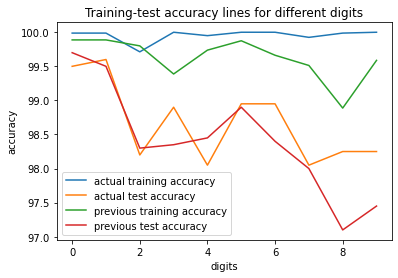

In [272]:
sum_graph = df.plot(title = 'Training-test accuracy lines for different digits', xlabel = 'digits', ylabel = 'accuracy')
sum_graph

In [273]:
df_weight = pd.DataFrame(np.array([best_weighted_avg,best_weighted_avg_test_acc,weighted_avg,weighted_avg_test_acc]).T,
              columns = ['best weighted training accuracy','best weighted test accuracy','previous weighted training accuracy','previous weighted test accuracy'],
                 index = list(np.arange(10)))
df_weight

,best weighted training accuracy,best weighted test accuracy,previous weighted training accuracy,previous weighted test accuracy
0,99.9875,99.65,99.9375,99.40
1,100.0000,99.65,99.8125,99.40
2,99.9125,98.45,99.8750,98.65
3,100.0000,98.85,99.5000,98.75
4,99.9750,98.30,99.9500,98.65
5,100.0000,98.90,99.8625,98.85
6,99.9875,98.95,99.9000,98.65
7,99.9625,98.10,99.7500,98.20
8,99.9875,98.15,99.7125,97.75
9,100.0000,98.25,99.7500,97.95


<AxesSubplot:title={'center':'Training-test accuracy lines for different digits in weighted average'}, xlabel='digits', ylabel='accuracy'>

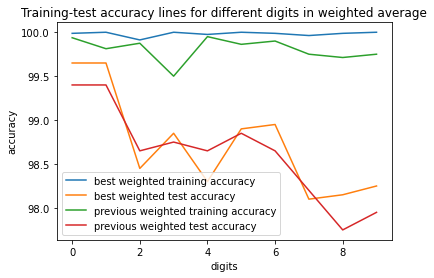

In [274]:
sum_graph1 = df_weight.plot(title = 'Training-test accuracy lines for different digits in weighted average', xlabel = 'digits', ylabel = 'accuracy')
sum_graph1

In [275]:
df_compare = pd.DataFrame(np.array([new_best_tr_acc,new_best_test_acc,cross_new_best_tr_acc,cross_new_best_test_acc]).T,
              columns = ['validation training accuracy','validation test accuracy','cross actual training accuracy','cross actual test accuracy'],
                 index = list(np.arange(10)))
df_compare

,validation training accuracy,validation test accuracy,cross actual training accuracy,cross actual test accuracy
0,99.9875,99.50,100.0000,99.65
1,99.9875,99.60,100.0000,99.65
2,99.7125,98.20,100.0000,98.80
3,100.0000,98.90,100.0000,98.75
4,99.9500,98.05,99.5875,98.45
5,100.0000,98.95,100.0000,98.85
6,100.0000,98.95,100.0000,98.95
7,99.9250,98.05,99.8875,97.85
8,99.9875,98.25,100.0000,98.15
9,100.0000,98.25,99.9500,98.15


<AxesSubplot:title={'center':'CV vs validation set: Accuracy lines for different digits '}, xlabel='digits', ylabel='accuracy'>

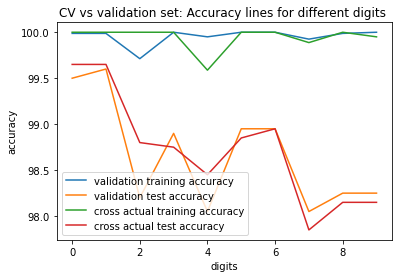

In [276]:
sum_graph_compare = df_compare.plot(title = 'CV vs validation set: Accuracy lines for different digits ', xlabel = 'digits', ylabel = 'accuracy')
sum_graph_compare

In [277]:
prova = pd.DataFrame(np.array([best_tr_acc,min_tr_test_acc,cross_new_best_tr_acc,cross_new_best_test_acc]).T,
              columns = ['previous training accuracy','previous test accuracy','cross actual training accuracy','cross actual test accuracy'],
                 index = list(np.arange(10)))
prova

,previous training accuracy,previous test accuracy,cross actual training accuracy,cross actual test accuracy
0,99.8875,99.70,100.0000,99.65
1,99.8875,99.50,100.0000,99.65
2,99.8000,98.30,100.0000,98.80
3,99.3875,98.35,100.0000,98.75
4,99.7375,98.45,99.5875,98.45
5,99.8750,98.90,100.0000,98.85
6,99.6625,98.40,100.0000,98.95
7,99.5125,98.00,99.8875,97.85
8,98.8875,97.10,100.0000,98.15
9,99.5875,97.45,99.9500,98.15


<AxesSubplot:title={'center':'CV-accuracies vs previous ERM accuracies'}, xlabel='digits', ylabel='accuracy'>

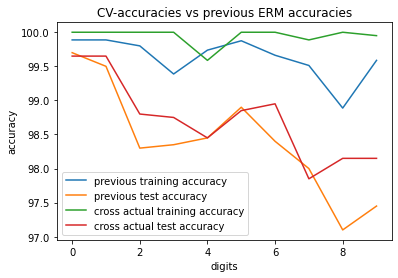

In [278]:
pro = prova.plot(title = 'CV-accuracies vs previous ERM accuracies', xlabel = 'digits', ylabel = 'accuracy')
pro

In [336]:
cross = pd.DataFrame(np.array([best_weighted_avg,best_weighted_avg_test_acc,cross_best_weighted_avg,cross_best_weighted_avg_test_acc]).T,
              columns = ['validation weighted training accuracy','validation weighted test accuracy','CV weighted training accuracy','CV weighted test accuracy'],
                 index = list(np.arange(10)))
cross

,validation weighted training accuracy,validation weighted test accuracy,CV weighted training accuracy,CV weighted test accuracy
0,99.9875,99.65,99.9875,99.60
1,100.0000,99.65,100.0000,99.65
2,99.9125,98.45,99.9875,98.80
3,100.0000,98.85,100.0000,98.75
4,99.9750,98.30,99.9625,98.95
5,100.0000,98.90,100.0000,99.05
6,99.9875,98.95,99.9875,98.95
7,99.9625,98.10,99.9875,98.15
8,99.9875,98.15,100.0000,98.30
9,100.0000,98.25,100.0000,98.25


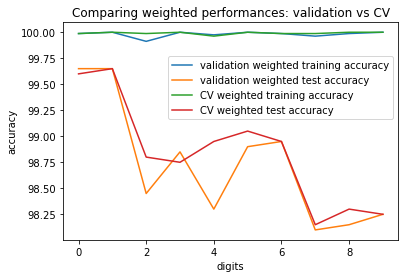

In [337]:
cross_table = cross.plot(title = 'Comparing weighted performances: validation vs CV', xlabel = 'digits', ylabel = 'accuracy')
cross_table
cross_table.legend(loc = 'center right',bbox_to_anchor=(1.0, 0.7))

## Multiclass predictions

### validation best pred

In [279]:
def multiclass_pred(array):
    preidctions = []
    for el in array:
        pred = el.index(max(el))
        predictions.append(pred)
    return predictions

def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

In [280]:
# ordering predictions
array_act = np.array(activations_report).T

In [281]:
list_array_act = array_act.tolist()
list_array_act

[[-2.418119096272679e+33,
  -2.8548697848455478e+26,
  -2.0592672327513203e+33,
  -1.880562254638636e+33,
  -1.936351227162667e+33,
  -3.8257015077379004e+39,
  -1.4229552440280426e+20,
  1.426232662442788e+20,
  -7.361049482813942e+26,
  -7.53707970835942e+26],
 [-7.512429674745481e+33,
  -5.009129833243367e+26,
  2.9279402658547105e+33,
  -3.785271486746025e+33,
  -3.233851851112354e+33,
  -2.1454007759317345e+40,
  -2.3967247702682694e+20,
  -1.6692409289974484e+20,
  -1.185086405254578e+27,
  -8.648868515860393e+26],
 [-1.301626449358609e+32,
  2.945728553548184e+25,
  -1.0616962873703295e+32,
  -2.7606420821192137e+32,
  -7.291632390658206e+31,
  -2.674820250393409e+38,
  -2.994006861072337e+19,
  -1.3353285406346988e+19,
  -5.218778412435092e+25,
  -6.3852243445113834e+25],
 [4.00075844665766e+34,
  -1.679111084658832e+27,
  -2.921336579573986e+34,
  -3.2861139634794276e+34,
  -3.587452841610478e+34,
  -1.3763831923870354e+41,
  -6.010156719289796e+20,
  -3.101158589027857e+20,
 

In [282]:
predictions = []
for el in list_array_act:
    pred = el.index(max(el))
    predictions.append(pred)

In [283]:
actual = list(mnist_test[:2000].label)

In [284]:
accuracy_metric(actual,predictions)

92.4

### validation weighted

In [285]:
# ordering predictions
array_weighted_act = np.array(weighted_activations_report).T

In [286]:
list_weighted_array_act = array_weighted_act.tolist()
list_weighted_array_act 

[[-2.4605902535843726e+33,
  -2.4504718262110347e+26,
  -1.9420942689322277e+33,
  -1.8556713176679713e+33,
  -1.9335781323896485e+33,
  -3.811367004950352e+39,
  -1.4247111514807914e+20,
  1.4087164958764671e+20,
  -7.26691640958335e+26,
  -7.488031643579227e+26],
 [-6.626617472116108e+33,
  -4.642532866734585e+26,
  3.31417977416501e+33,
  -3.2896359091031995e+33,
  -3.209620418378395e+33,
  -2.1541083529680728e+40,
  -2.320358644594498e+20,
  -1.6774581943725126e+20,
  -1.1309318498057681e+27,
  -8.651383659017653e+26],
 [-1.3654965809701205e+32,
  3.1379684362256026e+25,
  -1.0315334393061961e+32,
  -2.7200825668564987e+32,
  -7.322560068384861e+31,
  -2.6558411539227252e+38,
  -2.970462931828725e+19,
  -1.1956455362020536e+19,
  -4.960393469061562e+25,
  -6.2075427724282714e+25],
 [4.194040502796942e+34,
  -1.623302728057469e+27,
  -2.55991892901344e+34,
  -3.402251980431805e+34,
  -3.6048186389618933e+34,
  -1.365880258889857e+41,
  -6.115924619603572e+20,
  -3.2228364943135906e+

In [287]:
predictions_weighted = []
for el in list_weighted_array_act:
    pred = el.index(max(el))
    predictions_weighted.append(pred)
predictions == predictions_weighted

False

In [288]:
accuracy_metric(actual,predictions_weighted)

92.95

In [289]:
predictions

[7,
 2,
 1,
 0,
 4,
 1,
 4,
 9,
 6,
 9,
 0,
 6,
 9,
 0,
 1,
 5,
 9,
 7,
 3,
 4,
 9,
 6,
 6,
 5,
 4,
 0,
 7,
 4,
 0,
 1,
 3,
 1,
 3,
 4,
 7,
 2,
 7,
 1,
 2,
 1,
 1,
 7,
 4,
 2,
 3,
 5,
 1,
 2,
 4,
 4,
 6,
 3,
 5,
 5,
 6,
 0,
 4,
 1,
 9,
 5,
 7,
 8,
 9,
 3,
 7,
 4,
 6,
 4,
 3,
 0,
 7,
 0,
 2,
 9,
 1,
 7,
 3,
 2,
 9,
 7,
 9,
 6,
 2,
 7,
 8,
 4,
 7,
 3,
 6,
 1,
 3,
 6,
 9,
 3,
 1,
 4,
 1,
 7,
 6,
 9,
 6,
 0,
 5,
 4,
 9,
 9,
 2,
 1,
 9,
 4,
 8,
 7,
 3,
 9,
 2,
 4,
 4,
 4,
 9,
 2,
 5,
 4,
 7,
 6,
 4,
 9,
 0,
 5,
 8,
 5,
 6,
 6,
 5,
 7,
 8,
 1,
 0,
 1,
 6,
 4,
 6,
 7,
 3,
 1,
 7,
 1,
 8,
 2,
 0,
 2,
 9,
 8,
 5,
 5,
 1,
 5,
 4,
 0,
 3,
 4,
 4,
 6,
 5,
 4,
 6,
 5,
 4,
 5,
 1,
 4,
 4,
 7,
 2,
 3,
 2,
 7,
 1,
 8,
 1,
 8,
 1,
 8,
 5,
 0,
 8,
 9,
 2,
 5,
 0,
 1,
 1,
 1,
 0,
 4,
 0,
 3,
 1,
 6,
 4,
 2,
 3,
 6,
 1,
 1,
 1,
 3,
 9,
 5,
 2,
 9,
 4,
 5,
 9,
 3,
 9,
 0,
 3,
 6,
 5,
 5,
 7,
 7,
 2,
 7,
 1,
 2,
 8,
 4,
 1,
 7,
 3,
 3,
 8,
 7,
 7,
 9,
 2,
 2,
 4,
 1,
 5,
 8,
 8,
 7,
 2,
 3,
 0,
 2,
 4,
 2,


In [290]:
count = 0
for el in range(len(predictions)):
    if predictions[el] != predictions_weighted[el]:
        count += 1
count        

32

### CV best pred

In [291]:
# ordering predictions
cross_array_act = np.array(cross_activations_report).T

In [292]:
cross_list_array_act = cross_array_act.tolist()
cross_list_array_act

[[-47538355537989.0,
  -2.8485458726793272e+26,
  -3.736168398178974e+26,
  -1.0987834227154226e+20,
  -38596725197413.0,
  -30608710492251.0,
  -1.4229552440280426e+20,
  1.4626348656423148e+20,
  -2.5124580251568295e+33,
  -3.359967031744735e+33],
 [-66822631891504.0,
  -4.930895806583791e+26,
  -3.867482088833359e+25,
  -1.532492390556654e+20,
  -56946393454420.0,
  -54881401051625.0,
  -2.3967247702682694e+20,
  -1.558143811502004e+20,
  -9.670045191416649e+33,
  -2.8242498442288006e+33],
 [-15068469939346.0,
  3.79985672197426e+25,
  -4.363465192347923e+25,
  -4.002310771653505e+19,
  -6299584022942.0,
  -16769043002316.0,
  -2.994006861072337e+19,
  -1.571219236570967e+19,
  -3.1593222261477533e+31,
  -1.2814716065432493e+32],
 [69009466836833.0,
  -1.7258544183649102e+27,
  -4.419239309626664e+27,
  -4.777672322897245e+20,
  -98105074344731.0,
  -76410981709713.0,
  -6.010156719289796e+20,
  -3.741332454123e+20,
  -6.24527814215327e+34,
  -2.8933233623740704e+34],
 [-36728962091

In [293]:
cross_predictions = []
for el in cross_list_array_act:
    pred = el.index(max(el))
    cross_predictions.append(pred)

In [294]:
accuracy_metric(actual,cross_predictions)

91.95

### CV weighted pred

In [295]:
cross_array_weighted_act = np.array(cross_weighted_activations_report).T

In [296]:
cross_list_weighted_array_act = cross_array_weighted_act.tolist()
cross_list_weighted_array_act 

[[-42660263249512.66,
  -2.762831721242056e+26,
  -3.690917039989698e+26,
  -1.0683546902835593e+20,
  -37093413849423.28,
  -27017146907421.56,
  -1.4247111514807914e+20,
  1.426374605350445e+20,
  -2.4909018424556043e+33,
  -3.188267778772923e+33],
 [-62780944417477.08,
  -4.863842793704783e+26,
  7.384464730335136e+25,
  -1.495609000608801e+20,
  -53216488239379.11,
  -56406531979219.72,
  -2.320358644594498e+20,
  -1.6850230028446797e+20,
  -9.789414638765309e+33,
  -2.683599954616002e+33],
 [-15328995310787.678,
  3.732753848598788e+25,
  -4.1220826562607334e+25,
  -3.6736970245305356e+19,
  -7113186963561.246,
  -15963550960590.258,
  -2.970462931828725e+19,
  -1.2936182753928178e+19,
  -3.8484812639009784e+31,
  -1.295134447728967e+32],
 [77897794285323.56,
  -1.7020811789806092e+27,
  -4.227932354189366e+27,
  -4.790208825256124e+20,
  -95372481916718.17,
  -74116759919007.0,
  -6.115924619603572e+20,
  -3.463821784518453e+20,
  -6.118924677046955e+34,
  -2.714350099378571e+34]

In [297]:
cross_predictions_weighted = []
for el in cross_list_weighted_array_act:
    pred = el.index(max(el))
    cross_predictions_weighted.append(pred)

In [298]:
accuracy_metric(actual,cross_predictions_weighted)

92.4

In [299]:
count = 0
for el in range(len(predictions)):
    if cross_predictions_weighted[el] != predictions_weighted[el]:
        count += 1
count        

168

## MULTICLASSIFICATION WITH FIXEX HYPERPARAMETERS

This last section is aimed to determine multiclassification performances when the binary classifiers have the same hyperparameters and they are not singularly previously tuned and whether the performances are better or worse.

In [300]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


def kern(x1,x2,d=2,c=1):
    pre = c + np.dot(x1.T,x2)
    ret = pre**d
    return ret

def mapps(array):
    return ([kern(array[k][:-1],array[row_index][:-1]) for row_index in range(len(array)) for k in range(len(array))])

def splits(array,n_examples):
    return([array[i:i+n_examples] for i in range(0,n_examples**2,n_examples)])

def mapps_2(array,d):
    map = np.array([[None]*len(array)]*len(array))
    for row_index in range(len(array)):
        for k in range(row_index,len(array)):
                value = kern(array[k][:-1],array[row_index][:-1],d)
                map[row_index][k] = value
                map[k][row_index] = value
    return np.matrix(map)  

### Mapps_2 faster than mapps/split, they perform the same task.
# Mapps_2 possible only because the kernel matrices are symmetric ----> Mercer's theorem

def predict_test(train,test,alpha, row_index,d):
    activation = 0
    for k in range(len(train)):
        activation += alpha[k]*kern(train[k][:-1],test[row_index][:-1],d)  
    return (1.0 if activation >= 0.0 else -1.0,activation)

def predict_2(array,alpha, row_index, kernels):
    activation = np.dot(kernels[row_index],alpha)
    return 1.0 if activation >= 0.0 else -1.0

def train_kern_alpha(train, n_epoch, kernels): #train --> dataset to train
    alpha_list = []
    alpha = np.array([0.0 for i in range(len(train))])
    n_errors = []
    for epoch in range(n_epoch):
        sum_error = 0.0
        for i in range(len(train)):
            prediction = predict_2(train, alpha, i, kernels)
            error = (train[i][-1] - prediction)/2
            sum_error += error**2
            alpha[i] += error
        print('>epoch=%d, error=%.3f' % (epoch, sum_error))
        c = list(alpha).copy()
        n_errors.append(sum_error)
        alpha_list.append(c)
    print('average error = %2f' % (sum(n_errors)/len(n_errors)))    
    return (alpha,alpha_list,n_errors)

# train_kern_alpha(xtrainsmall,8)
# type(kern(xtrainsmall[0],xtrainsmall[1])) == np.float64 #True

def kernel_perceptron(train, test, n_epoch, kernels,d):
    predictions_tr = list()
    predictions_test = list()
    activations = []
    alpha,alpha_list,errors = train_kern_alpha(train, n_epoch, kernels)
    print(alpha)
    for row in range(len(train)):
        prediction = predict_2(train,alpha,row,kernels)
        predictions_tr.append(prediction)
    for row in range(len(test)):
        prediction, active = predict_test(train,test,alpha,row,d)
        predictions_test.append(prediction)
        activations.append(active)
    return(predictions_tr,predictions_test,alpha_list,errors,activations)

def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

def alpha_avg(alpha_list):
    avg = []
    for i in range(len(alpha_list[0])):
        count = 0
        for l in range(len(alpha_list)):
            count += alpha_list[l][i]
        avg.append(count/len(alpha_list))
    return avg

def weight_avg(alpha_list, scaled_n_err):
    avg = []
    for i in range(len(alpha_list[0])):
        count = 0
        for l in range(len(alpha_list)):
            count += alpha_list[l][i]*scaled_n_err[l]
        avg.append(count)
    return avg

def scaling(n_err):
    scaling = []
    for i in n_err:
        if i == 0:
            scaling.append(i)
        else:    
            scaling.append(1/i)
    scaled = []
    for el in scaling:
        scaled.append(el/sum(scaling))
    return scaled 

# It works faster !!!

def mapps_kernels(train, var_grid):
    mapkern = {}
    for deg in var_grid[1]['degree_pol']:
        kern = mapps_2(train, deg)
        mapkern[deg] = kern
    return mapkern    


def validation(train, test, var_grid, mapkern):
    initial_activations = []
    variables_accuracy = []
    for deg in var_grid[1]['degree_pol']:
        deg_accuracy = {}
        activations = []
        for epoch in var_grid[0]['n_epochs']:
            predicted_tr,predicted_test,alpha_list,err,activated = kernel_perceptron(train,test, epoch, mapkern[deg],deg)
            actual = [row[-1] for row in test]
            acc = accuracy_metric(actual, predicted_test)
            print('ploynomial_degree=%.3f, epoch=%d, accuracy=%.2f ' % (deg, epoch, acc))
            deg_accuracy[(deg, epoch)] = acc
            activations.append(activated)
        variables_accuracy.append(deg_accuracy)
        initial_activations.append(activations)
    return (variables_accuracy,initial_activations)   

def preparing_plot(validated):
    index = []
    for i in range(len(validated)):
        index.append(list(validated[i].keys())[0][0])
    epoch = []
    for l in range(len(validated[0])):
        epoch.append(list(validated[0].keys())[l][1])   
    accuracies = []
    for d in range(len(validated)):   
        accuracies.append(list(validated[d].values()))
    return(index, epoch, accuracies)   

def selection(performances,accumulator):
    select = {}
    for i in performances:
        for l in i:
            if i[l] == max(list(i.values())):
                select[l] = max(list(i.values()))
    max_acc = {}
    for l in select:
        if select[l] == max(list(select.values())):
            max_acc[l] = max(list(select.values()))

    list_epoch = []
    for el in list(max_acc.keys()):    
        list_epoch.append(el[1])
    list_deg = []
    last_sel = {}
    for es in max_acc:
        if es[1] == min(list_epoch):
            last_sel[es] = list(max_acc.values())[0]
    list_deg = []
    for el in list(last_sel.keys()):    
        list_deg.append(el[0])
    for es in last_sel:
        if es[0] == min(list_deg):
            accumulator.append((es,list(last_sel.values())[0]))

In [301]:
multi_selected_param = [] 
multi_prev = []

In [302]:
var_grid = [{'n_epochs':range(5,15,3)},{'degree_pol': range(2,8)}]

### DIGIT 0

In [303]:
xtrain = np.array(onehot_digit0)
xtest = np.array(onehot_digit0_test)
train = xtrain[:8000]
test = xtest[:2000]
mapkern = mapps_kernels(train, var_grid)
multi_validated_accuracies,multi_active0 = validation(train, test, var_grid, mapkern) 
multi_prev.append(multi_active0)
selection(multi_validated_accuracies, multi_selected_param)

>epoch=0, error=141.000
>epoch=1, error=46.000
>epoch=2, error=35.000
>epoch=3, error=17.000
>epoch=4, error=23.000
average error = 52.400000
[-1.  1. -1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=99.20 
>epoch=0, error=141.000
>epoch=1, error=46.000
>epoch=2, error=35.000
>epoch=3, error=17.000
>epoch=4, error=23.000
>epoch=5, error=10.000
>epoch=6, error=15.000
>epoch=7, error=4.000
average error = 36.375000
[-1.  1. -1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=8, accuracy=99.65 
>epoch=0, error=141.000
>epoch=1, error=46.000
>epoch=2, error=35.000
>epoch=3, error=17.000
>epoch=4, error=23.000
>epoch=5, error=10.000
>epoch=6, error=15.000
>epoch=7, error=4.000
>epoch=8, error=0.000
>epoch=9, error=0.000
>epoch=10, error=0.000
average error = 26.454545
[-1.  1. -1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=11, accuracy=99.65 
>epoch=0, error=141.000
>epoch=1, error=46.000
>epoch=2, error=35.000
>epoch=3, error=17.000
>epoch=4, error=23.000
>epoch=5, erro

### DIGIT 1

In [304]:
xtrain = np.array(onehot_digit1)
xtest = np.array(onehot_digit1_test)
train = xtrain[:8000]
test = xtest[:2000]
multi_validated_accuracies,multi_active1 = validation(train, test, var_grid, mapkern) 
multi_prev.append(multi_active1)
selection(multi_validated_accuracies, multi_selected_param)

>epoch=0, error=123.000
>epoch=1, error=61.000
>epoch=2, error=50.000
>epoch=3, error=38.000
>epoch=4, error=23.000
average error = 59.000000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=99.50 
>epoch=0, error=123.000
>epoch=1, error=61.000
>epoch=2, error=50.000
>epoch=3, error=38.000
>epoch=4, error=23.000
>epoch=5, error=17.000
>epoch=6, error=12.000
>epoch=7, error=17.000
average error = 42.625000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=8, accuracy=99.35 
>epoch=0, error=123.000
>epoch=1, error=61.000
>epoch=2, error=50.000
>epoch=3, error=38.000
>epoch=4, error=23.000
>epoch=5, error=17.000
>epoch=6, error=12.000
>epoch=7, error=17.000
>epoch=8, error=6.000
>epoch=9, error=5.000
>epoch=10, error=10.000
average error = 32.909091
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=11, accuracy=99.60 
>epoch=0, error=123.000
>epoch=1, error=61.000
>epoch=2, error=50.000
>epoch=3, error=38.000
>epoch=4, error=23.000
>epoch=5, e

### DIGIT 2

In [305]:
xtrain = np.array(onehot_digit2)
xtest = np.array(onehot_digit2_test)
train = xtrain[:8000]
test = xtest[:2000]
multi_validated_accuracies,multi_active2 = validation(train, test, var_grid, mapkern) 
multi_prev.append(multi_active2)
selection(multi_validated_accuracies, multi_selected_param)

>epoch=0, error=252.000
>epoch=1, error=91.000
>epoch=2, error=57.000
>epoch=3, error=48.000
>epoch=4, error=16.000
average error = 92.800000
[-1.  0. -1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=98.30 
>epoch=0, error=252.000
>epoch=1, error=91.000
>epoch=2, error=57.000
>epoch=3, error=48.000
>epoch=4, error=16.000
>epoch=5, error=18.000
>epoch=6, error=23.000
>epoch=7, error=15.000
average error = 65.000000
[-1.  0. -1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=8, accuracy=98.45 
>epoch=0, error=252.000
>epoch=1, error=91.000
>epoch=2, error=57.000
>epoch=3, error=48.000
>epoch=4, error=16.000
>epoch=5, error=18.000
>epoch=6, error=23.000
>epoch=7, error=15.000
>epoch=8, error=20.000
>epoch=9, error=10.000
>epoch=10, error=4.000
average error = 50.363636
[-1.  0. -1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=11, accuracy=98.65 
>epoch=0, error=252.000
>epoch=1, error=91.000
>epoch=2, error=57.000
>epoch=3, error=48.000
>epoch=4, error=16.000
>epoch=5, 

### DIGIT 3

In [306]:
xtrain = np.array(onehot_digit3)
xtest = np.array(onehot_digit3_test)
train = xtrain[:8000]
test = xtest[:2000]
multi_validated_accuracies,multi_active3 = validation(train, test, var_grid, mapkern) 
multi_prev.append(multi_active3)
selection(multi_validated_accuracies, multi_selected_param)

>epoch=0, error=283.000
>epoch=1, error=132.000
>epoch=2, error=81.000
>epoch=3, error=65.000
>epoch=4, error=41.000
average error = 120.400000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=98.35 
>epoch=0, error=283.000
>epoch=1, error=132.000
>epoch=2, error=81.000
>epoch=3, error=65.000
>epoch=4, error=41.000
>epoch=5, error=46.000
>epoch=6, error=29.000
>epoch=7, error=21.000
average error = 87.250000
[-2.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=8, accuracy=98.70 
>epoch=0, error=283.000
>epoch=1, error=132.000
>epoch=2, error=81.000
>epoch=3, error=65.000
>epoch=4, error=41.000
>epoch=5, error=46.000
>epoch=6, error=29.000
>epoch=7, error=21.000
>epoch=8, error=22.000
>epoch=9, error=17.000
>epoch=10, error=17.000
average error = 68.545455
[-2.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=11, accuracy=98.15 
>epoch=0, error=283.000
>epoch=1, error=132.000
>epoch=2, error=81.000
>epoch=3, error=65.000
>epoch=4, error=41.000
>epo

### DIGIT 4

In [307]:
xtrain = np.array(onehot_digit4)
xtest = np.array(onehot_digit4_test)
train = xtrain[:8000]
test = xtest[:2000]
multi_validated_accuracies,multi_active4 = validation(train, test, var_grid, mapkern) 
multi_prev.append(multi_active4)
selection(multi_validated_accuracies, multi_selected_param)

>epoch=0, error=234.000
>epoch=1, error=78.000
>epoch=2, error=42.000
>epoch=3, error=22.000
>epoch=4, error=29.000
average error = 81.000000
[-1.  0.  1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=98.65 
>epoch=0, error=234.000
>epoch=1, error=78.000
>epoch=2, error=42.000
>epoch=3, error=22.000
>epoch=4, error=29.000
>epoch=5, error=14.000
>epoch=6, error=24.000
>epoch=7, error=8.000
average error = 56.375000
[-1.  0.  1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=8, accuracy=98.45 
>epoch=0, error=234.000
>epoch=1, error=78.000
>epoch=2, error=42.000
>epoch=3, error=22.000
>epoch=4, error=29.000
>epoch=5, error=14.000
>epoch=6, error=24.000
>epoch=7, error=8.000
>epoch=8, error=7.000
>epoch=9, error=4.000
>epoch=10, error=18.000
average error = 43.636364
[-1.  0.  1. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=11, accuracy=98.55 
>epoch=0, error=234.000
>epoch=1, error=78.000
>epoch=2, error=42.000
>epoch=3, error=22.000
>epoch=4, error=29.000
>epoch=5, err

### DIGIT 5

In [308]:
xtrain = np.array(onehot_digit5)
xtest = np.array(onehot_digit5_test)
train = xtrain[:8000]
test = xtest[:2000]
multi_validated_accuracies,multi_active5 = validation(train, test, var_grid, mapkern) 
multi_prev.append(multi_active5)
selection(multi_validated_accuracies, multi_selected_param)

>epoch=0, error=248.000
>epoch=1, error=100.000
>epoch=2, error=73.000
>epoch=3, error=39.000
>epoch=4, error=32.000
average error = 98.400000
[ 0. -1.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=98.90 
>epoch=0, error=248.000
>epoch=1, error=100.000
>epoch=2, error=73.000
>epoch=3, error=39.000
>epoch=4, error=32.000
>epoch=5, error=21.000
>epoch=6, error=20.000
>epoch=7, error=13.000
average error = 68.250000
[ 0. -1.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=8, accuracy=98.45 
>epoch=0, error=248.000
>epoch=1, error=100.000
>epoch=2, error=73.000
>epoch=3, error=39.000
>epoch=4, error=32.000
>epoch=5, error=21.000
>epoch=6, error=20.000
>epoch=7, error=13.000
>epoch=8, error=10.000
>epoch=9, error=5.000
>epoch=10, error=2.000
average error = 51.181818
[ 0. -1.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=11, accuracy=98.85 
>epoch=0, error=248.000
>epoch=1, error=100.000
>epoch=2, error=73.000
>epoch=3, error=39.000
>epoch=4, error=32.000
>epoch=

### DIGIT 6

In [309]:
xtrain = np.array(onehot_digit6)
xtest = np.array(onehot_digit6_test)
train = xtrain[:8000]
test = xtest[:2000]
multi_validated_accuracies,multi_active6 = validation(train, test, var_grid, mapkern) 
multi_prev.append(multi_active6)
selection(multi_validated_accuracies, multi_selected_param)

>epoch=0, error=165.000
>epoch=1, error=77.000
>epoch=2, error=49.000
>epoch=3, error=21.000
>epoch=4, error=18.000
average error = 66.000000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=98.40 
>epoch=0, error=165.000
>epoch=1, error=77.000
>epoch=2, error=49.000
>epoch=3, error=21.000
>epoch=4, error=18.000
>epoch=5, error=11.000
>epoch=6, error=5.000
>epoch=7, error=0.000
average error = 43.250000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=8, accuracy=98.85 
>epoch=0, error=165.000
>epoch=1, error=77.000
>epoch=2, error=49.000
>epoch=3, error=21.000
>epoch=4, error=18.000
>epoch=5, error=11.000
>epoch=6, error=5.000
>epoch=7, error=0.000
>epoch=8, error=0.000
>epoch=9, error=0.000
>epoch=10, error=0.000
average error = 31.454545
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=11, accuracy=98.85 
>epoch=0, error=165.000
>epoch=1, error=77.000
>epoch=2, error=49.000
>epoch=3, error=21.000
>epoch=4, error=18.000
>epoch=5, error=

### DIGIT 7

In [310]:
xtrain = np.array(onehot_digit7)
xtest = np.array(onehot_digit7_test)
train = xtrain[:8000]
test = xtest[:2000]
multi_validated_accuracies,multi_active7 = validation(train, test, var_grid, mapkern) 
multi_prev.append(multi_active7)
selection(multi_validated_accuracies, multi_selected_param)

>epoch=0, error=207.000
>epoch=1, error=96.000
>epoch=2, error=66.000
>epoch=3, error=34.000
>epoch=4, error=38.000
average error = 88.200000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=97.75 
>epoch=0, error=207.000
>epoch=1, error=96.000
>epoch=2, error=66.000
>epoch=3, error=34.000
>epoch=4, error=38.000
>epoch=5, error=43.000
>epoch=6, error=29.000
>epoch=7, error=20.000
average error = 66.625000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=8, accuracy=97.70 
>epoch=0, error=207.000
>epoch=1, error=96.000
>epoch=2, error=66.000
>epoch=3, error=34.000
>epoch=4, error=38.000
>epoch=5, error=43.000
>epoch=6, error=29.000
>epoch=7, error=20.000
>epoch=8, error=16.000
>epoch=9, error=10.000
>epoch=10, error=4.000
average error = 51.181818
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=11, accuracy=98.45 
>epoch=0, error=207.000
>epoch=1, error=96.000
>epoch=2, error=66.000
>epoch=3, error=34.000
>epoch=4, error=38.000
>epoch=5, 

### DIGIT 8

In [311]:
xtrain = np.array(onehot_digit8)
xtest = np.array(onehot_digit8_test)
train = xtrain[:8000]
test = xtest[:2000]
multi_validated_accuracies,multi_active8 = validation(train, test, var_grid, mapkern) 
multi_prev.append(multi_active8)
selection(multi_validated_accuracies, multi_selected_param)

>epoch=0, error=396.000
>epoch=1, error=146.000
>epoch=2, error=106.000
>epoch=3, error=69.000
>epoch=4, error=53.000
average error = 154.000000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=97.10 
>epoch=0, error=396.000
>epoch=1, error=146.000
>epoch=2, error=106.000
>epoch=3, error=69.000
>epoch=4, error=53.000
>epoch=5, error=43.000
>epoch=6, error=36.000
>epoch=7, error=23.000
average error = 109.000000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=8, accuracy=97.85 
>epoch=0, error=396.000
>epoch=1, error=146.000
>epoch=2, error=106.000
>epoch=3, error=69.000
>epoch=4, error=53.000
>epoch=5, error=43.000
>epoch=6, error=36.000
>epoch=7, error=23.000
>epoch=8, error=11.000
>epoch=9, error=0.000
>epoch=10, error=0.000
average error = 80.272727
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=11, accuracy=98.10 
>epoch=0, error=396.000
>epoch=1, error=146.000
>epoch=2, error=106.000
>epoch=3, error=69.000
>epoch=4, error=53.000
>

### DIGIT 9

In [312]:
xtrain = np.array(onehot_digit9)
xtest = np.array(onehot_digit9_test)
train = xtrain[:8000]
test = xtest[:2000]
multi_validated_accuracies,multi_active9 = validation(train, test, var_grid, mapkern) 
multi_prev.append(multi_active9)
selection(multi_validated_accuracies, multi_selected_param)

>epoch=0, error=383.000
>epoch=1, error=187.000
>epoch=2, error=100.000
>epoch=3, error=92.000
>epoch=4, error=85.000
average error = 169.400000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=5, accuracy=97.45 
>epoch=0, error=383.000
>epoch=1, error=187.000
>epoch=2, error=100.000
>epoch=3, error=92.000
>epoch=4, error=85.000
>epoch=5, error=49.000
>epoch=6, error=21.000
>epoch=7, error=40.000
average error = 119.625000
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=8, accuracy=97.50 
>epoch=0, error=383.000
>epoch=1, error=187.000
>epoch=2, error=100.000
>epoch=3, error=92.000
>epoch=4, error=85.000
>epoch=5, error=49.000
>epoch=6, error=21.000
>epoch=7, error=40.000
>epoch=8, error=19.000
>epoch=9, error=19.000
>epoch=10, error=12.000
average error = 91.545455
[-1.  0.  0. ...  0.  0.  0.]
ploynomial_degree=2.000, epoch=11, accuracy=98.05 
>epoch=0, error=383.000
>epoch=1, error=187.000
>epoch=2, error=100.000
>epoch=3, error=92.000
>epoch=4, error=85.000

In [313]:
multi_big = []
for i in range(len(multi_prev[0])):
    less_big = []
    for b in range(len(multi_prev[0][0])):
        less_less_big = []
        for el in range(len(multi_prev)):
            less_less_big.append(multi_prev[el][i][b])
        less_big.append(less_less_big)
    multi_big.append(less_big)  

In [317]:
degep = []
for z in range(len(multi_prev[0])):
    we = []
    for i in range(len(multi_prev[0][0])):
        epoch_var = []
        for el in range(len(multi_prev)):
            epoch_var.append(multi_prev[el][z][i])
        we.append(epoch_var)
    degep.append(we)
print(np.array(degep).shape)
multipred = []
for q in degep:
    zx = []
    for ef in q:
        intern = []
        for b in ((np.array(ef).T).tolist()):
            pred = b.index(max(b))
            intern.append(pred)  
        zx.append(intern)
    multipred.append(zx)
actual = list(mnist_test[:2000].label)
print(np.array(multipred).shape)
print(multipred[0][0])
cumulative = []
for q in multipred:
    rt = []
    for er in q:
        rt.append(accuracy_metric(actual, er))
    cumulative.append(rt)
cumulative

(6, 4, 10, 2000)
(6, 4, 2000)
[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 8, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 4, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 5, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 7, 7, 9, 2, 2, 4, 1, 5, 8, 8, 7, 2, 3, 0, 2, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 0, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 8, 2, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 2, 4, 0, 2, 7, 4, 3, 3, 0, 0, 3, 1, 9, 6, 5, 2, 5, 1, 7, 9, 

[[93.55, 94.3, 94.25, 94.6],
 [94.55, 95.25, 95.25, 95.25],
 [94.5, 94.55, 94.55, 94.55],
 [93.85, 94.45, 94.55, 94.55],
 [93.75, 93.75, 93.75, 93.75],
 [92.9, 92.9, 92.9, 92.9]]

In [318]:
multi_z_var = []
for el in cumulative:
    for w in el:
        multi_z_var.append(w)
multi_z_var

[93.55,
 94.3,
 94.25,
 94.6,
 94.55,
 95.25,
 95.25,
 95.25,
 94.5,
 94.55,
 94.55,
 94.55,
 93.85,
 94.45,
 94.55,
 94.55,
 93.75,
 93.75,
 93.75,
 93.75,
 92.9,
 92.9,
 92.9,
 92.9]

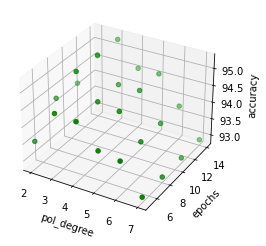

In [319]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

z = multi_z_var
x = [2]*4+[3]*4+[4]*4+[5]*4+[6]*4 + [7]*4
y = [5,8,11,14]*6


ax.scatter(x, y, z, c='green', marker='o')

ax.set_xlabel('pol_degree')
ax.set_ylabel('epochs')
ax.set_zlabel('accuracy')

plt.show()